# Notebook 03: Time Series Forecasting - Quarterly

This notebook forecasts Q2, Q3, and Q4 sales for watches using the data cleaned in [Notebook 1: Data Cleaning](01_data_cleaning.ipynb).

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.var import VAR

from sklearn.metrics import mean_squared_error

import random

# custom function imports
from custom_functions import *
from forecasting_custom_functions import *

In [2]:
df_models = pd.read_csv('../data/cleaned_datasets/df_models.csv')

# Keep only items in the proposal that have previous sales
df_models.dropna(subset='proposal_priority',inplace=True)

time_now = datetime.datetime.now()
df_models.dropna(subset=time_now.strftime(f"%Y-%m"),inplace=True)

# Transform so that datetime is the index, and style_id is the colum
y = return_sales(df_models,'style_id')

# Resample so now quarterly
y = y.resample('Q',kind='period').sum()

# Reduce size of y to previous quarter
previous_quarter_time = time_now - pd.Timedelta(365/4, unit='d')
previous_quarter = previous_quarter_time.strftime(f"%Y%Q{(previous_quarter_time.month - 1 ) // 3 + 1}")

y = y.loc[:previous_quarter,:]

# Sort values by 2022Q1 sales
y.sort_values(axis='columns',by = ['2022Q1'], ascending=False, inplace=True)

In [2]:
df_models = pd.read_csv('../data/cleaned_datasets/df_models.csv')

# Keep only items in the proposal that have previous sales
df_models.dropna(subset='proposal_priority',inplace=True)

time_now = datetime.datetime.now()
df_models.dropna(subset=time_now.strftime(f"%Y-%m"),inplace=True)

# Transform so that datetime is the index, and style_id is the colum
y = return_sales(df_models,'style_id')

# Resample so now quarterly
y = y.resample('Q',kind='period').sum()

# Sort values by 2022Q1 sales
y.sort_values(axis='columns',by = ['2022Q1'], ascending=False, inplace=True)

# Reduce size of y to previous quarter
previous_quarter_time = time_now - pd.Timedelta(365/4, unit='d')
previous_quarter = previous_quarter_time.strftime(f"%Y%Q{(previous_quarter_time.month - 1 ) // 3 + 1}")

y = y.loc[:previous_quarter,:]

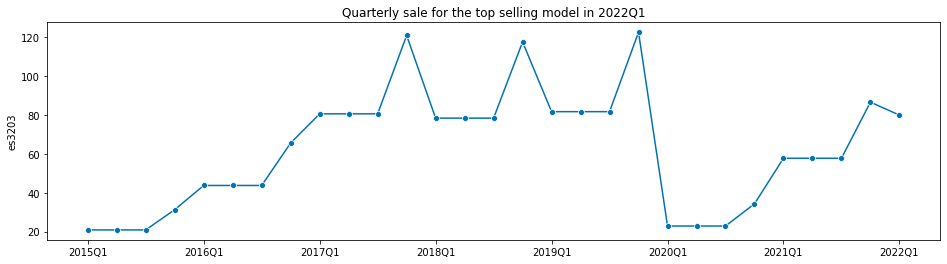

In [3]:
plot_series(y.iloc[:,0])
plt.title('Quarterly sale for the top selling model in 2022Q1');

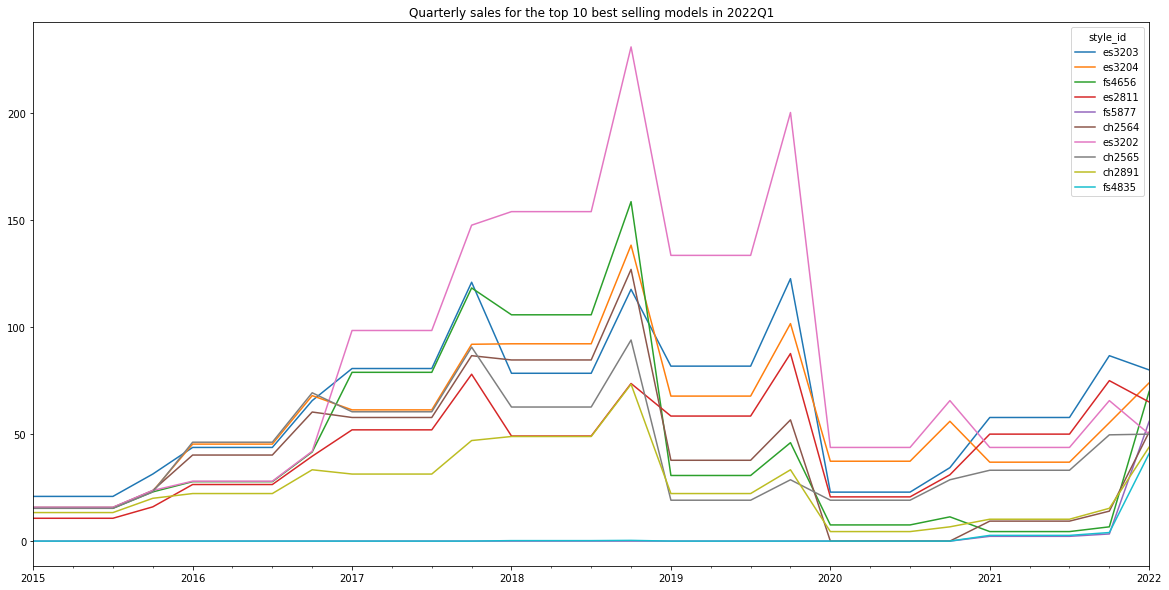

In [4]:
y.iloc[:,0:10].plot(figsize=(20,10),title='Quarterly sales for the top 10 best selling models in 2022Q1');

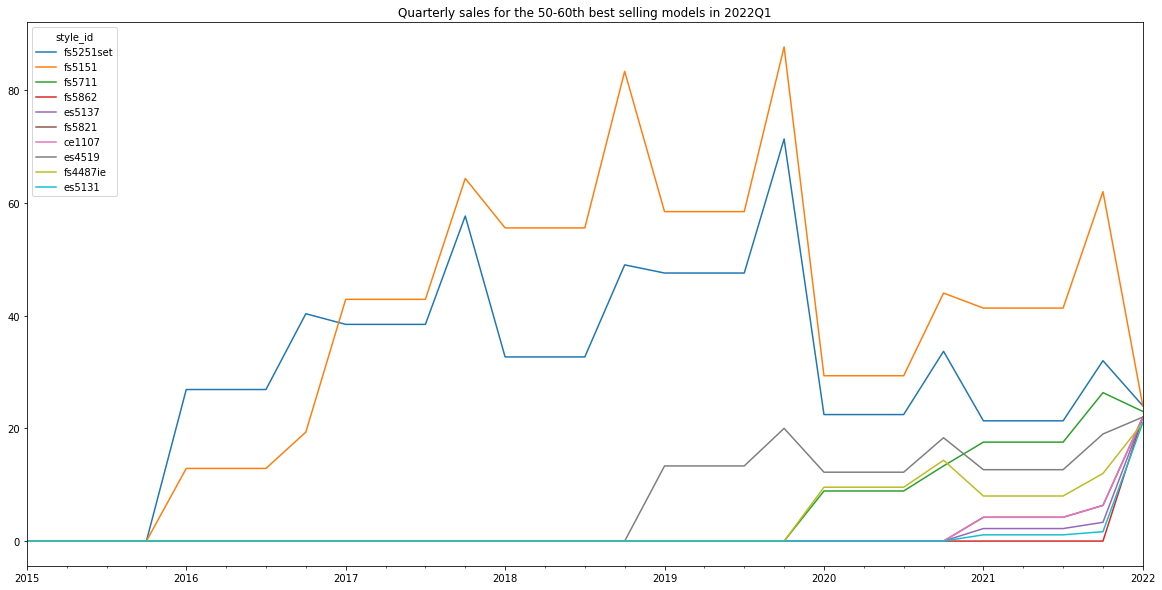

In [5]:
y.iloc[:,50:60].plot(figsize=(20,10),title='Quarterly sales for the 50-60th best selling models in 2022Q1');

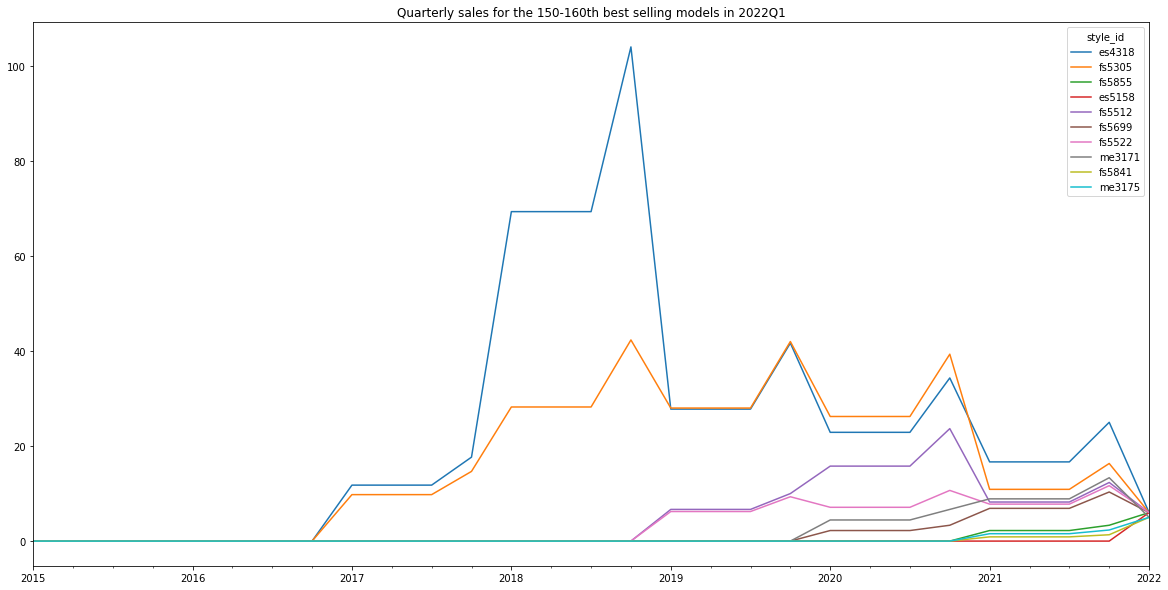

In [6]:
y.iloc[:,150:160].plot(figsize=(20,10),title='Quarterly sales for the 150-160th best selling models in 2022Q1');

#### Temporal TTS

In [7]:
y_train, y_test = temporal_train_test_split(y, test_size=1)

In [8]:
y_train.shape

(28, 265)

In [9]:
y_test.shape

(1, 265)

### Baseline model using last value

In [10]:
baseline_last = NaiveForecaster() # default strategy is last

In [11]:
baseline_last.fit(y_train)

NaiveForecaster()

In [12]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 28 entries, 2015Q1 to 2021Q4
Freq: Q-DEC
Columns: 265 entries, es3203 to me3220
dtypes: float64(265)
memory usage: 58.2 KB


In [13]:
pred_freq_list = [1,2,3,4]
baseline_last_preds = baseline_last.predict(pred_freq_list)

In [14]:
baseline_last_rmse = pred_rmse(y_test, baseline_last_preds)
baseline_last_rmse

12.9175420681243

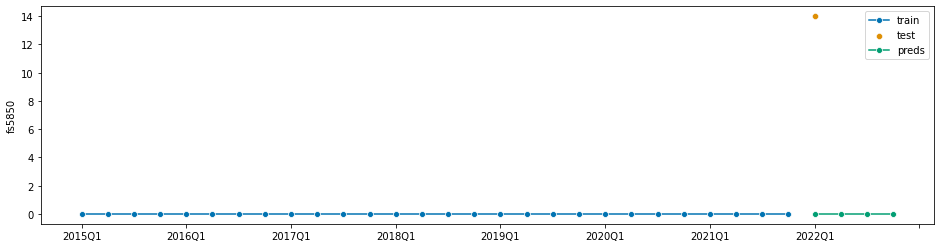

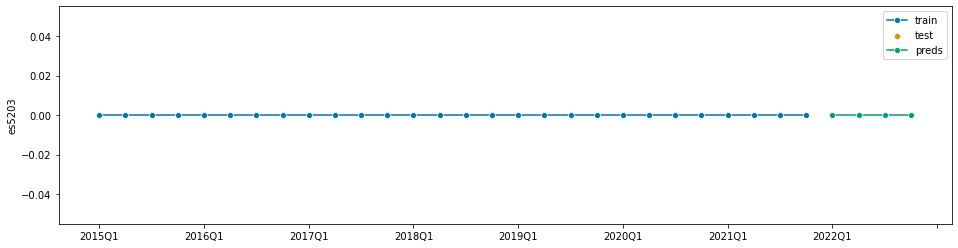

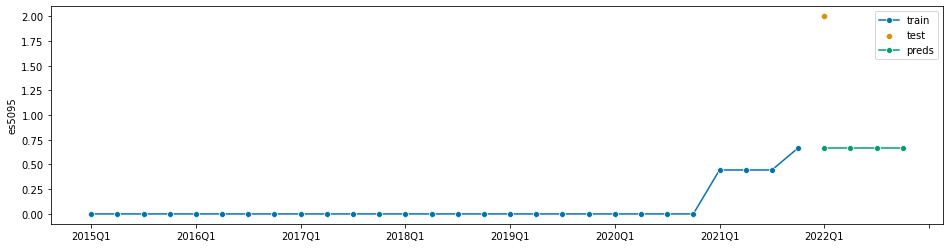

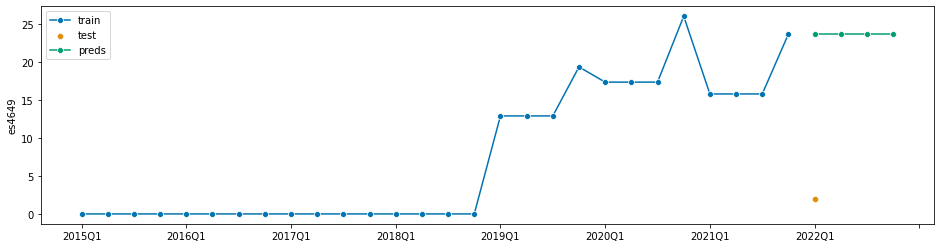

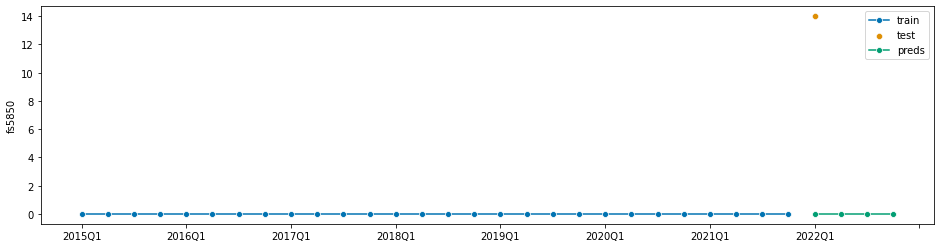

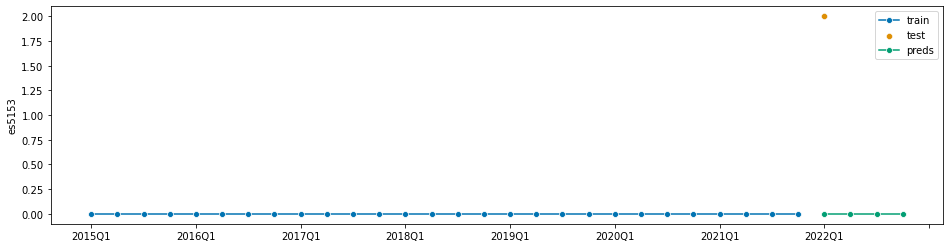

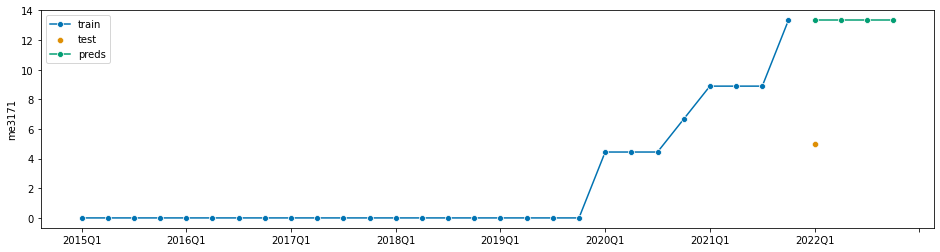

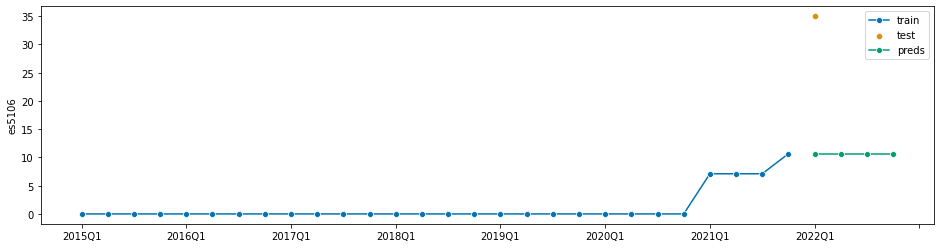

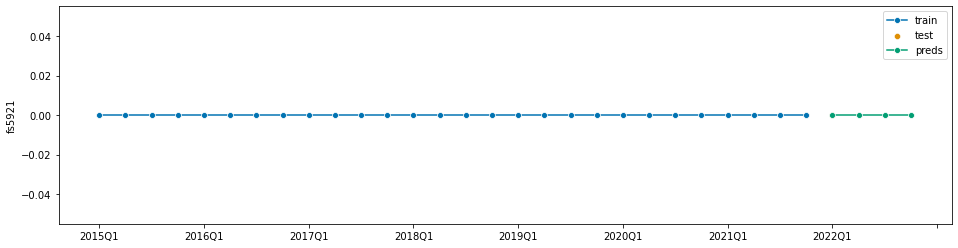

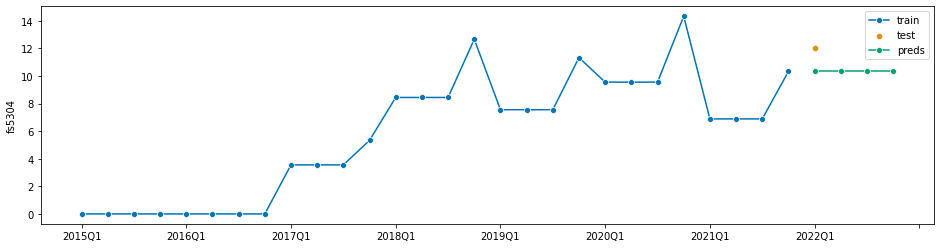

In [15]:
plot_pred(y_train, y_test, baseline_last_preds)

### Baseline model using drift

In [16]:
baseline_drift = NaiveForecaster(strategy='drift')
baseline_drift.fit(y_train)
baseline_drift_preds = baseline_drift.predict(pred_freq_list)
pred_rmse(y_test,baseline_drift_preds)

13.116478048531903

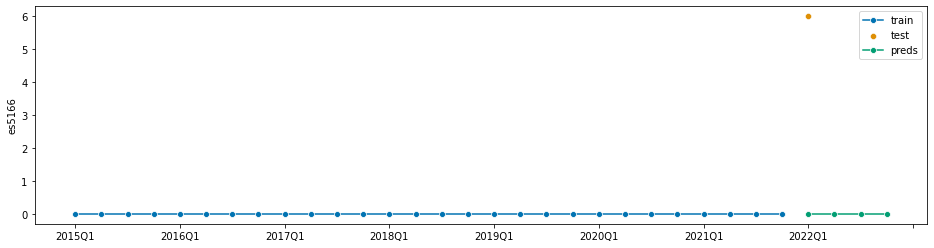

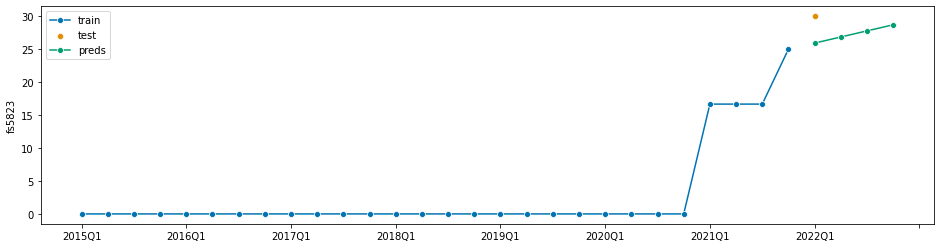

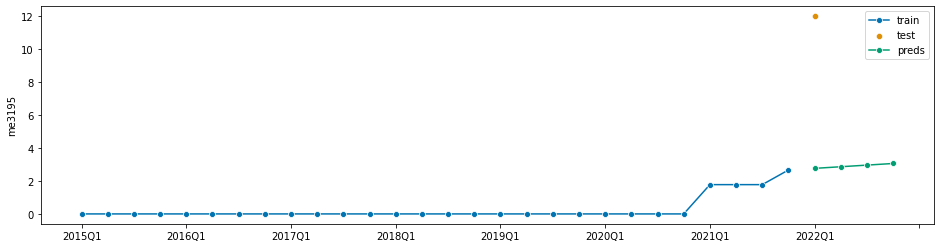

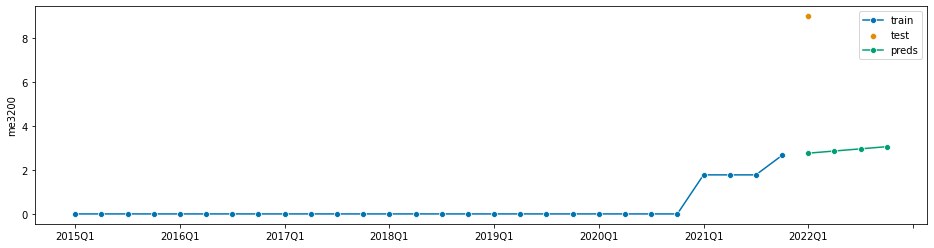

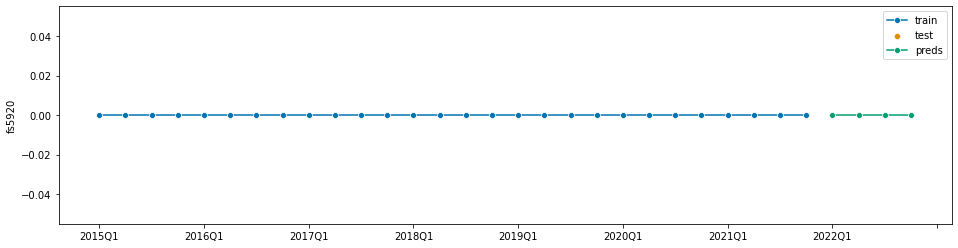

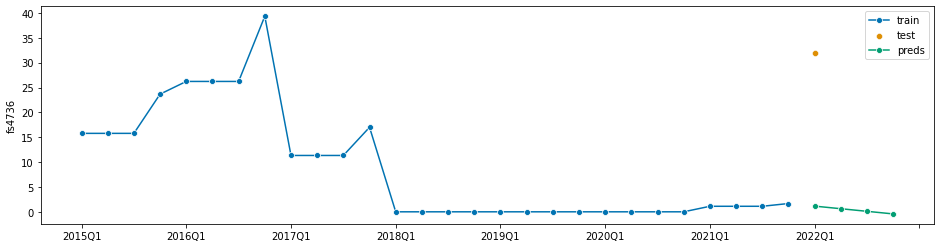

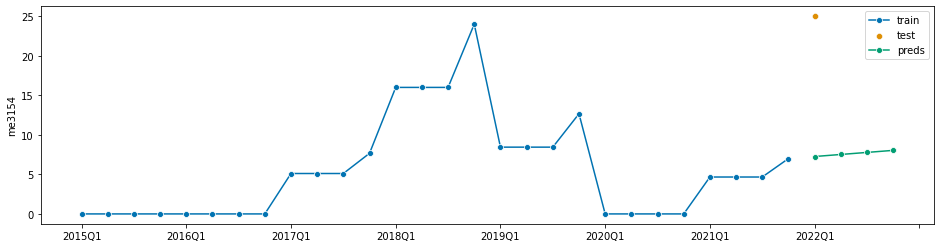

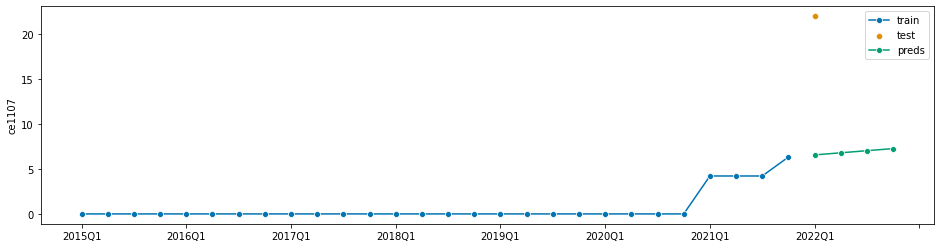

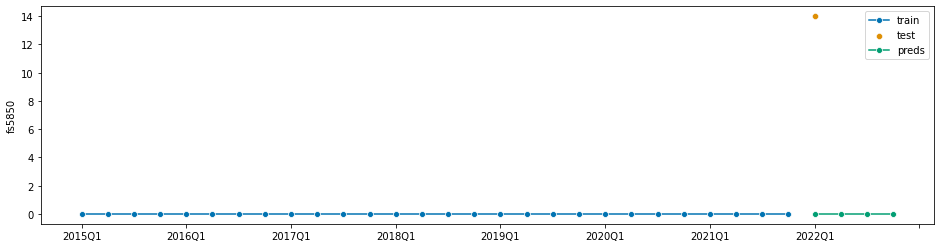

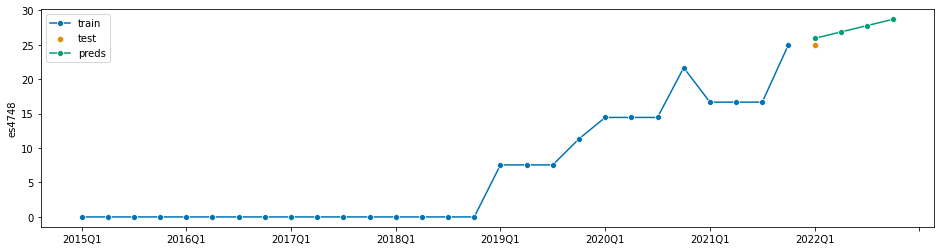

In [17]:
plot_pred(y_train,y_test,baseline_drift_preds)

### Baseline last seasonal cycle (quarterly)

In [18]:
baseline_seasonal = NaiveForecaster(strategy='last',sp=4)
baseline_seasonal.fit(y_train)
baseline_seasonal_preds = baseline_seasonal.predict(pred_freq_list)
pred_rmse(y_test, baseline_seasonal_preds)

12.758056059192713

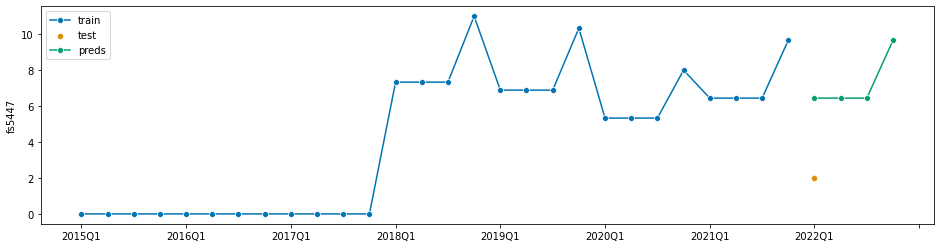

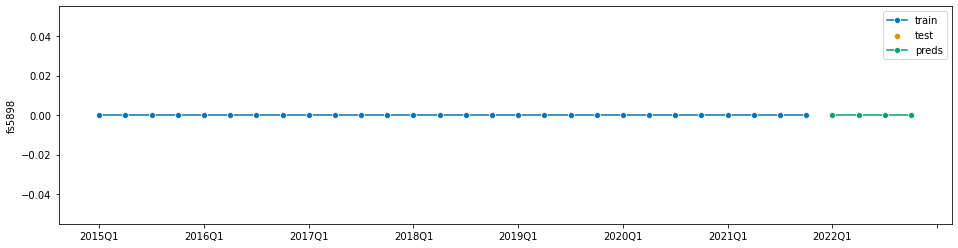

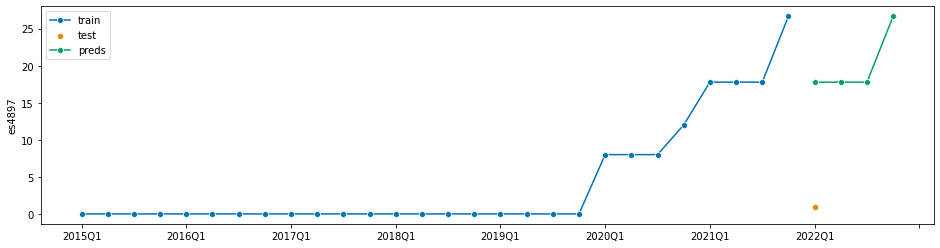

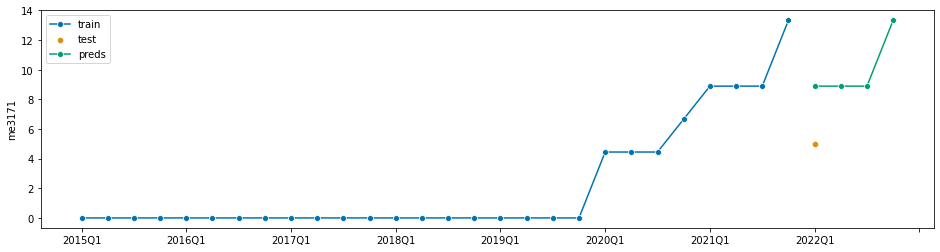

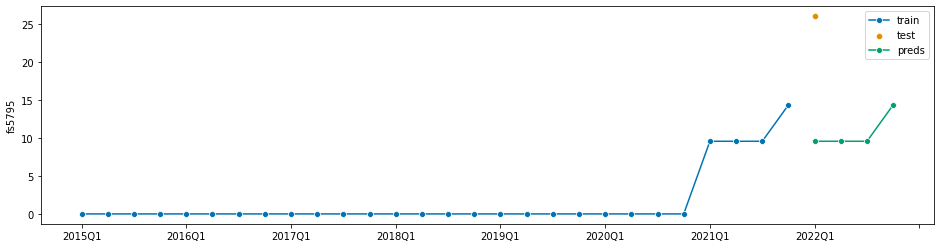

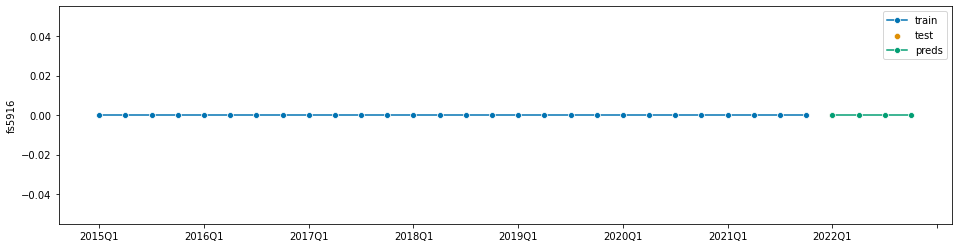

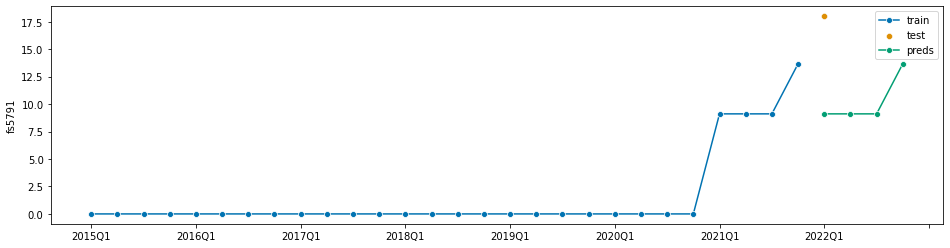

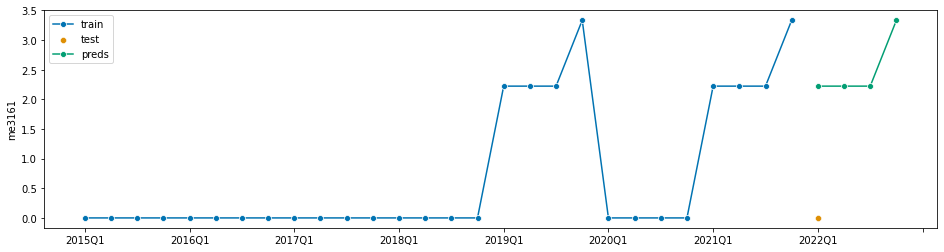

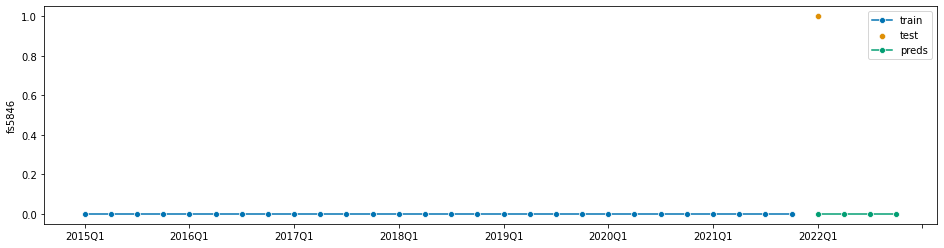

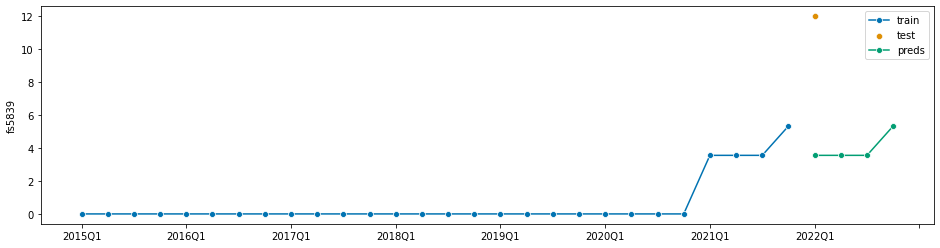

In [19]:
plot_pred(y_train, y_test, baseline_seasonal_preds)

### SARIMA

In [36]:
# # Used this to generate SARIMA predictions
# sarima_preds = pd.DataFrame()
# for model in y_train:
#     sarima_model = AutoARIMA(sp=4, trace=True)
#     print(model)
#     sarima_model.fit(y_train[model])
#     try:
#         sarima_preds[model] = sarima_model.predict(1)
#     except:
#         sarima_preds[model] = np.nan
# sarima_preds.T.to_csv('../data/predictions/sarima_preds.csv')

es3203
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=275.153, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=264.401, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=269.583, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=318.759, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=265.330, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=265.201, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=266.028, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=265.282, Time=0.05 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=265.514, Time=0.16 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=275.587, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=266.214, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=266.263, Time=0.12 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=269.030, Time=0.07 sec
 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=267.759, Time=0.16 sec
 ARIMA(1,0,0)(1,0,0)[4]      

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=206.124, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=208.314, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=207.779, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=204.229, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=207.949, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=207.818, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=206.614, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=206.515, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=208.515, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.115 seconds
fs4656
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=273.746, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=292.630, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=269.726, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=274.122, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=311.086, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=272.500, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=268.409, Time=0.18 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=270.409, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=268.774, Time=0.18 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=278.088, Time=0.10 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=270.043, Time=0.34 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=270.118, Time=0.11 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=273.044, Time=0.13 sec
 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=272.022, Time=0.25 sec
 ARIMA(1,0,0)(2,0,0)[4]             : AIC=269.644, Time=0.06 sec

Best model:  ARIMA(1,0,0

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=252.284, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=254.831, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=245.156, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=250.340, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=298.211, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=244.484, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=245.680, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=245.999, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=245.976, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=246.039, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=249.385, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=246.583, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=247.980, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.347 seconds
fs5877
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=46.664, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=55.570, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=53.272, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=53.681, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=44.728, Time=0.29 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=42.797, Time=0.13 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=44.754, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=42.335, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=44.297, Time=0.11 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=44.179, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=45.704, Time=0.25 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=41.761, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=43.727, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=43.728, Time=0.07 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=45.727, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=51.274, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=41.495, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=43.226, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=43.047, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=45.015, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=40.390, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=42.290, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=42.293, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=44.289, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=40.008, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=-15.042, Time=0.07 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=43.965, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,1)[4]             : AIC=43.965, Time=0.10 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=41.968, Time=0.06 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=45.965, Time=0.09 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=51.420, Time=0.04 sec
 ARIMA(2,2,1)(1,0,0)[4]             : AIC=42.121, Time=0.08 sec
 ARIMA(1,2,1)(1,0,0)[4]             : AIC=43.614, Time=0.05 sec
 ARIMA(3,2,1)(1,0,0)[4]             : AIC=44.121, Time=0.12 sec

Best model:  ARIMA(2,2,0)(1,0,0)[4]          
Total fit time: 4.094 seconds
ch2564
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=254.577, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=278.151, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=253.877, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=259.283, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=301.675, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=258.789, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=252.431, Time=0.11 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=254.185, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=253.615, Time=0.15 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=261.620, Time=0.09 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=254.177, Time=0.13 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=254.239, Time=0.12 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=256.779, Time=0.10 sec
 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=256.146, Time=0.21 sec
 ARIMA(1,0,0)(2,0,0)[4]             : AIC=254.162, Time=0.05 sec

Best model:  ARIMA(1,0,0

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=248.648, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=268.773, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=252.701, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=256.676, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=266.955, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,2)(0,1,1)[4] intercept   : AIC=246.452, Time=0.30 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters exce

 ARIMA(2,0,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,2)(0,1,2)[4] intercept   : AIC=inf, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters exce

 ARIMA(2,0,2)(1,1,0)[4] intercept   : AIC=inf, Time=0.35 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,0,2)(1,1,2)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,0,2)(0,1,1)[4] intercept   : AIC=254.753, Time=0.16 sec
 ARIMA(2,0,1)(0,1,1)[4] intercept   : AIC=255.070, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

 ARIMA(3,0,2)(0,1,1)[4] intercept   : AIC=inf, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,0,3)(0,1,1)[4] intercept   : AIC=248.488, Time=0.32 sec
 ARIMA(1,0,1)(0,1,1)[4] intercept   : AIC=253.112, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,0,3)(0,1,1)[4] intercept   : AIC=inf, Time=0.30 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.28 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn

 ARIMA(3,0,3)(0,1,1)[4] intercept   : AIC=inf, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,2)(0,1,1)[4]             : AIC=248.510, Time=0.26 sec

Best model:  ARIMA(2,0,2)(0,1,1)[4] intercept
Total fit time: 4.595 seconds
ch2565
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=248.182, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=258.343, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=241.425, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=246.938, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=297.063, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=245.961, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=241.749, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=242.556, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=241.309, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=240.315, Time=0.13 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,0)(0,0,2)[4] intercept   : AIC=242.218, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,0,1)(0,0,2)[4] intercept   : AIC=242.245, Time=0.23 sec
 ARIMA(0,0,1)(0,0,2)[4] intercept   : AIC=inf, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('N

 ARIMA(2,0,1)(0,0,2)[4] intercept   : AIC=244.189, Time=0.33 sec
 ARIMA(1,0,0)(0,0,2)[4]             : AIC=241.914, Time=0.08 sec

Best model:  ARIMA(1,0,0)(0,0,2)[4] intercept
Total fit time: 2.224 seconds
ch2891
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=224.570, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=240.428, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=220.714, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=225.202, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=271.108, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=224.825, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=221.074, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=221.252, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=219.316, Time=0.08 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=221.245, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=223.239, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=233.054, Time=0.04 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=220.950, Time=0.10 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=221.023, Time=0.11 sec
 ARIMA(2,0,1)(0,0,1)[4] intercept   : AIC=222.925, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[4]             : AIC=221.229, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,1)[4] intercept
Total fit time: 1.782 seconds
fs4835
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non

 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=46.877, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=50.536, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=46.649, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=48.635, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=inf, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting paramet

 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=48.755, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=48.745, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=50.745, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.208 seconds
es5130
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('No

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=10.741, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=19.526, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=17.229, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=17.637, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=8.698, Time=0.40 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=6.753, Time=0.47 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=8.719, Time=0.32 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=6.292, Time=0.13 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=8.253, Time=0.17 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=8.135, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=9.666, Time=0.36 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=5.717, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=7.683, Time=0.22 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=7.684, Time=0.10 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=9.683, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=15.230, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=5.451, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=7.182, Time=0.36 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=7.003, Time=0.36 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=8.971, Time=0.39 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=4.346, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=6.246, Time=0.16 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=6.250, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=8.245, Time=0.21 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=3.964, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5.922, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5.924, Time=0.07 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=7.921, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=13.377, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=4.078, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,0,0)[4]             : AIC=5.601, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=6.078, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 6.192 seconds
es5136
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.057 seconds
es3282
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starti

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=259.647, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=247.063, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=252.602, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=287.898, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=246.177, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=247.284, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=248.968, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=247.523, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=247.596, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=252.477, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=249.000, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=248.238, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.616 seconds
es5106
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercep

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=105.212, Time=0.18 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=103.281, Time=0.09 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=105.238, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=102.819, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=104.781, Time=0.09 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=103.331, Time=0.25 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=106.185, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=102.245, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=104.211, Time=0.05 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=104.211, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=106.211, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=111.757, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=101.979, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=103.710, Time=0.07 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=103.530, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=105.499, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=100.874, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=102.774, Time=0.05 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=102.777, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=104.773, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=100.492, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=102.449, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=102.451, Time=0.04 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=104.449, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[4]      

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=185.206, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=187.445, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=186.221, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=183.309, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=186.962, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=186.354, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=185.810, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=185.740, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=187.736, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 0.953 seconds
es4352
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=238.855, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=250.406, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=232.625, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=238.966, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=265.792, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=231.067, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=232.392, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=232.448, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=232.520, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=240.338, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=234.445, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=231.470, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.261 seconds
es5108
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercep

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,0)(0,0,0)[4]             : AIC=124.452, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=115.499, Time=0.19 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=113.567, Time=0.09 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=115.525, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=113.106, Time=0.04 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=115.068, Time=0.08 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=114.950, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=115.420, Time=0.40 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=112.532, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=114.498, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=114.498, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=116.498, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=122.044, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=112.266, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=113.997, Time=0.07 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=113.817, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=115.786, Time=0.20 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=111.161, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=113.061, Time=0.04 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=113.064, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA p

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=-0.861, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=7.922, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=5.625, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=6.034, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=-2.913, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=-4.850, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=-2.905, Time=0.29 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=-5.312, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=-3.350, Time=0.24 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=-3.468, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=-1.945, Time=0.32 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=-5.886, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=-3.920, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=-3.920, Time=0.23 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=-1.920, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=3.626, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=-6.152, Time=0.10 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=-4.421, Time=0.15 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=-4.601, Time=0.18 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=-2.632, Time=0.30 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=-7.257, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=-5.357, Time=0.11 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=-5.354, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=-3.358, Time=0.28 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=-7.639, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=-5.682, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=-5.679, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=-3.682, Time=0.21 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=1.773, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=-7.526, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=-6.003, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=-5.526, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 5.345 seconds
es4319
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=235.907, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=233.778, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=229.891, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=234.117, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=234.987, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=233.652, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=229.909, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=231.891, Time=0.10 sec
 ARIMA(0,1,2)(0,0,1)[4] intercept   : AIC=231.891, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=230.045, Time=0.07 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=233.887, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[4]             : AIC=228.153, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[4]             : AIC=233.406, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[4]             : AIC=inf, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,1,1)(0,0,2)[4]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(1,0,0)[4]             : AIC=231.826, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(1,0,2)[4]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,1)[4]             : AIC=228.057, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[4]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,2)[4]             : AIC=229.610, Time=0.07 sec
 ARIMA(0,1,0)(1,0,0)[4]             : AIC=231.810, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,1,0)(1,0,2)[4]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[4]             : AIC=228.269, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[4]             : AIC=229.746, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,1)[4]          
Total fit time: 3.552 seconds
es3466
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=194.246, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=189.004, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=191.600, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=226.305, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=187.838, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=189.275, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=189.797, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=189.811, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=189.981, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=191.749, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=192.463, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.271 seconds
es3433
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=290.913, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=310.142, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=286.227, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=291.101, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=333.110, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=290.803, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=284.173, Time=0.19 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=286.150, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=285.314, Time=0.30 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=292.479, Time=0.22 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=285.871, Time=0.21 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=285.939, Time=0.26 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=288.207, Time=0.21 sec
 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=287.839, Time=0.40 sec
 ARIMA(1,0,0)(2,0,0)[4]             : AIC=286.133, Time=0.07 sec

Best model:  ARIMA(1,0,0)(2,0,0)[4] intercept
Total fit time: 2.908 seconds
fs4736
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=186.045, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=183.072, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=184.194, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=184.908, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=180.860, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=180.913, Time=0.06 sec
 ARIMA(2,1,0)(2,0,0)[4] intercept   : AIC=182.655, Time=0.09 sec
 ARIMA(1,1,1)(2,0,0)[4] intercept   : AIC=182.690, Time=0.13 sec
 ARIMA(0,1,1)(2,0,0)[4] intercept   : AIC=180.700, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=182.938, Time=0.05 sec
 ARIMA(0,1,1)(2,0,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=inf

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,2)(2,0,0)[4] intercept   : AIC=184.481, Time=0.51 sec
 ARIMA(0,1,1)(2,0,0)[4]             : AIC=178.764, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[4]             : AIC=180.982, Time=0.03 sec
 ARIMA(0,1,1)(2,0,1)[4]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(1,0,1)[4]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(2,0,0)[4]             : AIC=178.926, Time=0.04 sec
 ARIMA(1,1,1)(2,0,0)[4]             : AIC=180.749, Time=0.09 sec
 ARIMA(0,1,2)(2,0,0)[4]             : AIC=180.742, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[4]             : AIC=178.902, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,2)(2,0,0)[4]             : AIC=182.586, Time=0.45 sec

Best model:  ARIMA(0,1,1)(2,0,0)[4]          
Total fit time: 4.095 seconds
es4433
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=148.290, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=149.643, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=148.865, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=147.183, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=149.120, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=148.799, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=150.764, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=149.055, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=148.943, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 1.194 seconds
jr1401
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=221.497, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=248.042, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=222.898, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=227.355, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=271.335, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=217.239, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[4] intercept   : AIC=232.259, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,2)(0,0,2)[4] intercept   : AIC=221.963, Time=0.40 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=228.308, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,0,2)(0,0,1)[4] intercept   : AIC=222.691, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting pa

 ARIMA(2,0,1)(0,0,1)[4] intercept   : AIC=222.834, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,0,2)(0,0,1)[4] intercept   : AIC=225.741, Time=0.38 sec
 ARIMA(2,0,3)(0,0,1)[4] intercept   : AIC=225.917, Time=0.15 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=220.926, Time=0.12 sec
 ARIMA(1,0,3)(0,0,1)[4] intercept   : AIC=223.970, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('N

 ARIMA(3,0,1)(0,0,1)[4] intercept   : AIC=220.988, Time=0.29 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn

 ARIMA(3,0,3)(0,0,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,0,2)(0,0,1)[4]             : AIC=224.314, Time=0.25 sec

Best model:  ARIMA(2,0,2)(0,0,1)[4] intercept
Total fit time: 4.871 seconds
es5107
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=105.488, Time=0.53 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=114.402, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=112.105, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=112.514, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=103.561, Time=0.21 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=101.630, Time=0.10 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=103.587, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=101.168, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=103.130, Time=0.12 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=103.012, Time=0.09 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=104.534, Time=0.61 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=100.594, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=102.560, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=102.560, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=104.560, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=110.107, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=100.328, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=102.059, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=101.879, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=103.848, Time=0.21 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=99.223, Time=0.09 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=101.123, Time=0.16 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=101.126, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=103.122, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=98.841, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=100.798, Time=0.19 sec
 ARIMA(2,2,0)(0,0,1)[4]        

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,0,0)[4]             : AIC=100.478, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=100.954, Time=0.10 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 4.945 seconds
jr1354
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=278.528, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=263.047, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=268.313, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=295.018, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=261.831, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=262.621, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=263.260, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=263.339, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=269.662, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=265.254, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=262.306, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 2.248 seconds
fs5772
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=169.559, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=168.264, Time=0.06 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=167.670, Time=0.02 sec
 ARIMA(0,2,0)(1,1,0)[4] intercept   : AIC=171.559, Time=0.03 sec
 ARIMA(0,2,0)(0,1,1)[4] intercept   : AIC=171.559, Time=0.03 sec
 ARIMA(0,2,0)(1,1,1)[4] intercept   : AIC=173.559, Time=0.03 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=166.265, Time=0.04 sec
 ARIMA(1,2,0)(0,1,1)[4] intercept   : AIC=168.264, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,2,0)(1,1,1)[4] intercept   : AIC=170.260, Time=0.42 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=158.651, Time=0.08 sec
 ARIMA(2,2,0)(1,1,0)[4] intercept   : AIC=160.621, Time=0.12 sec
 ARIMA(2,2,0)(0,1,1)[4] intercept   : AIC=160.621, Time=0.12 sec
 ARIMA(2,2,0)(1,1,1)[4] intercept   : AIC=162.621, Time=0.12 sec
 ARIMA(3,2,0)(0,1,0)[4] intercept   : AIC=158.685, Time=0.11 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=157.990, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=159.957, Time=0.16 sec
 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=159.933, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=161.982, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,2,1)(0,1,0)[4]             : AIC=157.339, Time=0.07 sec
 ARIMA(2,2,1)(1,1,0)[4]             : AIC=159.339, Time=0.21 sec
 ARIMA(2,2,1)(0,1,1)[4]             : AIC=159.339, Time=0.17 sec
 ARIMA(2,2,1)(1,1,1)[4]             : AIC=161.339, Time=0.13 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=158.285, Time=0.06 sec
 ARIMA(2,2,0)(0,1,0)[4]             : AIC=156.901, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,1,0)[4]             : AIC=158.861, Time=0.10 sec
 ARIMA(2,2,0)(0,1,1)[4]             : AIC=158.863, Time=0.17 sec
 ARIMA(2,2,0)(1,1,1)[4]             : AIC=160.861, Time=0.13 sec
 ARIMA(1,2,0)(0,1,0)[4]             : AIC=164.413, Time=0.02 sec
 ARIMA(3,2,0)(0,1,0)[4]             : AIC=157.580, Time=0.06 sec
 ARIMA(3,2,1)(0,1,0)[4]             : AIC=159.339, Time=0.12 sec

Best model:  ARIMA(2,2,0)(0,1,0)[4]          
Total fit time: 6.143 seconds
es5099
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=117.488, Time=0.58 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=126.340, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=124.043, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=124.452, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=115.499, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=113.567, Time=0.16 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=115.525, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=113.106, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=115.068, Time=0.15 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=114.950, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=115.420, Time=0.64 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=112.532, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=114.498, Time=0.09 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=114.498, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=116.498, Time=0.23 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=122.044, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=112.266, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=113.997, Time=0.11 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=113.817, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=115.786, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=111.161, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=113.061, Time=0.05 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=113.064, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=151.492, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=160.344, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=158.047, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=158.456, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=149.503, Time=0.19 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=147.572, Time=0.11 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=149.529, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=147.110, Time=0.06 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=149.072, Time=0.09 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=147.622, Time=0.26 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=150.476, Time=0.34 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=146.536, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=148.502, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=148.503, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=150.502, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=156.049, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=146.270, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=148.001, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=147.821, Time=0.13 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=149.790, Time=0.25 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=145.165, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=147.065, Time=0.05 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=147.068, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=149.064, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=144.783, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=146.740, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=146.743, Time=0.04 sec
 ARIMA(2,2,0)(1,0,1)[4]      

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameter

 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=155.476, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=145.326, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=150.340, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=159.973, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=143.383, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=144.765, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=145.223, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=145.259, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=148.345, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[4] intercept   : AIC=147.205, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[4]             : AIC=142.193, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[4]             : AIC=144.180, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,0,0)(0,1,1)[4]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(1,1,1)[4]             : AIC=inf, Time=0.33 sec
 ARIMA(2,0,0)(0,1,0)[4]             : AIC=143.833, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[4]             : AIC=143.886, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[4]             : AIC=150.381, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[4]             : AIC=145.828, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,1,0)[4]          
Total fit time: 2.378 seconds
fs4931
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=240.051, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=222.838, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=282.356, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=228.576, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=223.793, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=236.916, Time=0.13 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=224.464, Time=0.26 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=224.539, Time=0.31 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=229.098, Time=0.38 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=226.292, Time=0.39 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=224.733, Time=0.04 sec

Best model:  ARIMA(1,0,0)(1,0,0)[4] intercept
Total fit time: 3.896 seconds
es4627
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=94.124, Time=0.73 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=88.069, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=89.314, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=88.639, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=86.991, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=88.868, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=88.741, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=90.721, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=88.793, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=88.587, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.431 seconds
me3099
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=180.538, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=181.

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=247.237, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=255.263, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=239.640, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=246.132, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=271.838, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=237.867, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=239.632, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=241.632, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=239.298, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=239.372, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=245.963, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=241.293, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=238.382, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.580 seconds
fs5822
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=103.781, Time=0.60 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=112.697, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=110.400, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=110.809, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=101.856, Time=0.27 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=99.925, Time=0.20 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=101.882, Time=0.43 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=99.463, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=101.425, Time=0.10 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=101.307, Time=0.13 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=102.829, Time=0.28 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=98.889, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=100.855, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=100.855, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=102.855, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=108.401, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=98.623, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=100.354, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=100.174, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=102.143, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=97.518, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=99.418, Time=0.05 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=99.421, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=101.417, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=97.136, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=99.093, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=99.095, Time=0.04 sec
 ARIMA(2,2,0)(1,0,1)[4]             

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=121.843, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=121.988, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=120.632, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=120.124, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=121.583, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=120.784, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=122.604, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=122.596, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=122.494, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 0.998 seconds
es5109
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=110.353, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=119.206, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=117.317, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=108.364, Time=0.23 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=106.433, Time=0.11 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=108.390, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=105.972, Time=0.17 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=107.933, Time=0.16 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=107.815, Time=0.20 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=109.338, Time=0.37 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=105.397, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=107.363, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=107.364, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=109.363, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=114.910, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=105.131, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=106.862, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=106.683, Time=0.16 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=108.651, Time=0.19 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=104.026, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=105.926, Time=0.07 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=105.930, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=107.925, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=103.644, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=105.602, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=105.604, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4]      

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "


fs5883
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=-7.745, Time=0.94 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=-1.681, Time=0.06 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=-2.976, Time=0.25 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=-3.570, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,1,1)[4] intercept   : AIC=-9.800, Time=0.44 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=-11.778, Time=0.38 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,1,0)[4] intercept   : AIC=-9.665, Time=0.39 sec
 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=-13.250, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=-11.283, Time=0.51 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=-11.307, Time=0.37 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=-9.446, Time=0.50 sec
 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=-13.499, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(1,1,0)[4] intercept   : AIC=inf, Time=0.51 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,1,1)[4] intercept   : AIC=-11.489, Time=0.29 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(1,1,1)[4] intercept   : AIC=-9.463, Time=0.39 sec
 ARIMA(0,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=-4.975, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=-12.588, Time=0.07 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=-12.955, Time=0.05 sec

Best model:  ARIMA(1,2,1)(0,1,0)[4] intercept
Total fit time: 6.749 seconds
es4745
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=150.952, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=160.083, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=158.294, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=158.303, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=148.953, Time=0.13 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,2,2)(0,0,2)[4] intercept   : AIC=150.952, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=149.604, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(1,0,2)[4] intercept   : AIC=152.930, Time=0.51 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,2,2)(0,0,1)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=147.861, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,2,1)(0,0,2)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=inf, Time=0.31 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/st

 ARIMA(2,2,1)(1,0,2)[4] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=152.419, Time=0.24 sec
 ARIMA(3,2,1)(0,0,1)[4] intercept   : AIC=146.079, Time=0.92 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,2,1)(1,0,1)[4] intercept   : AIC=148.066, Time=0.60 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 ARIMA(3,2,1)(0,0,2)[4] intercept   : AIC=148.064, Time=0.51 sec
 ARIMA(3,2,1)(1,0,0)[4] intercept   : AIC=147.509, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,1)(1,0,2)[4] intercept   : AIC=150.057, Time=0.66 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=144.619, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=147.834, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=146.617, Time=0.37 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 ARIMA(3,2,0)(0,0,2)[4] intercept   : AIC=146.617, Time=0.23 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=145.707, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,0)(1,0,2)[4] intercept   : AIC=148.619, Time=0.26 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=145.760, Time=0.12 sec

Best model:  ARIMA(3,2,0)(0,0,1)[4] intercept
Total fit time: 9.331 seconds
jr1437
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=234.846, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=241.747, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=227.501, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=233.467, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=269.516, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=227.257, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=227.882, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=229.336, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=228.456, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=228.519, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=234.266, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=229.831, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=228.922, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.389 seconds
fs5795
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] inte

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=129.529, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=120.576, Time=0.33 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=118.645, Time=0.26 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=120.602, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=118.183, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=120.145, Time=0.10 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=120.027, Time=0.12 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=121.550, Time=0.33 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=117.609, Time=0.07 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=119.575, Time=0.10 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=119.576, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=121.575, Time=0.27 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=127.122, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=117.343, Time=0.09 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=119.074, Time=0.14 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=118.895, Time=0.18 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=120.863, Time=0.37 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=116.238, Time=0.07 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=118.138, Time=0.11 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=118.141, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=120.137, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=115.856, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]      

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=117.969, Time=0.19 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 5.476 seconds
fs5874
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=10.741, Time=0.58 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=19.526, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=17.229, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=17.637, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=8.698, Time=0.40 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=6.753, Time=0.43 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=8.719, Time=0.54 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=6.292, Time=0.15 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=8.253, Time=0.35 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=8.135, Time=0.28 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=9.666, Time=0.54 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=5.717, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=7.683, Time=0.29 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=7.684, Time=0.11 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=9.683, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=15.230, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=5.451, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=7.182, Time=0.29 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=7.003, Time=0.19 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=8.971, Time=0.42 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=4.346, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=6.246, Time=0.11 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=6.250, Time=0.13 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=8.245, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=3.964, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5.922, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5.924, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=7.921, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=13.377, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=4.078, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,0,0)[4]             : AIC=5.601, Time=0.56 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=6.078, Time=0.12 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 7.629 seconds
fs5712
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=142.997, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=152.853, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=150.724, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=151.101, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=141.020, Time=0.17 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.27 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,2)(0,0,2)[4] intercept   : AIC=142.998, Time=0.27 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=141.484, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(1,0,2)[4] intercept   : AIC=144.997, Time=0.47 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,2,2)(0,0,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=140.138, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=141.732, Time=0.24 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,1)(0,0,2)[4] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=140.192, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/st

 ARIMA(2,2,1)(1,0,2)[4] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=144.548, Time=0.07 sec
 ARIMA(3,2,1)(0,0,1)[4] intercept   : AIC=138.394, Time=0.20 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,2,1)(1,0,1)[4] intercept   : AIC=140.258, Time=0.24 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,1)(0,0,2)[4] intercept   : AIC=140.234, Time=0.35 sec
 ARIMA(3,2,1)(1,0,0)[4] intercept   : AIC=139.411, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,1)(1,0,2)[4] intercept   : AIC=142.228, Time=0.57 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=136.809, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=138.674, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=138.772, Time=0.20 sec
 ARIMA(3,2,0)(0,0,2)[4] intercept   : AIC=138.764, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=137.609, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,0)(1,0,2)[4] intercept   : AIC=140.758, Time=0.34 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=137.802, Time=0.07 sec

Best model:  ARIMA(3,2,0)(0,0,1)[4] intercept
Total fit time: 7.253 seconds
fs5459
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=185.737, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=188.013, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=187.031, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=185.469, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=186.652, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=185.854, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=187.826, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=187.251, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=187.217, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=189.217, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.924 seconds
fs5876
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=10.741, Time=0.56 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=19.526, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=17.229, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=17.637, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=8.698, Time=0.36 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=6.753, Time=0.40 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=8.719, Time=0.36 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=6.292, Time=0.16 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=8.253, Time=0.27 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=8.135, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=9.666, Time=0.39 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=5.717, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=7.683, Time=0.27 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=7.684, Time=0.57 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=9.683, Time=0.39 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=15.230, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=5.451, Time=0.21 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=7.182, Time=0.44 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=7.003, Time=0.32 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=8.971, Time=0.56 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=4.346, Time=0.08 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=6.246, Time=0.18 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=6.250, Time=0.17 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=8.245, Time=0.46 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=3.964, Time=0.10 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5.922, Time=0.15 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5.924, Time=0.14 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=7.921, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=13.377, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=4.078, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=5.601, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=6.078, Time=0.13 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 8.489 seconds
es4748
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=115.213, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=117.358, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=116.642, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=113.278, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=116.874, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=116.078, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=115.587, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=115.488, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=117.480, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.246 seconds
fs5707
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=10.741, Time=0.59 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=19.526, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=17.229, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=17.637, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=8.698, Time=0.31 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=6.753, Time=0.29 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=8.719, Time=0.55 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=6.292, Time=0.16 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=8.253, Time=0.25 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=8.135, Time=0.24 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=9.666, Time=0.41 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=5.717, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=7.683, Time=0.35 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=7.684, Time=0.28 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=9.683, Time=0.28 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=15.230, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=5.451, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=7.182, Time=0.39 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=7.003, Time=0.27 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=8.971, Time=0.44 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=4.346, Time=0.07 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=6.246, Time=0.14 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=6.250, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=8.245, Time=0.33 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=3.964, Time=0.08 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5.922, Time=0.13 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5.924, Time=0.10 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=7.921, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=13.377, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=4.078, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,0,0)[4]             : AIC=5.601, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=6.078, Time=0.12 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 7.803 seconds
me3154
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=186.820, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=169.958, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=200.559, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=168.843, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=170.347, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=170.421, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=177.263, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=172.339, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=169.154, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.206 seconds
es3716
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=181.042, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=168.872, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=175.094, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=179.341, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=168.068, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=167.731, Time=0.08 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,1,2)[4] intercept   : AIC=inf, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,0,0)(1,1,2)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=182.970, Time=0.06 sec
 ARIMA(2,0,0)(0,1,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.38 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,1,1)[4]             : AIC=165.790, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[4]             : AIC=166.290, Time=0.03 sec
 ARIMA(1,0,0)(1,1,1)[4]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,1,2)[4]             : AIC=inf, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,0,0)(1,1,0)[4]             : AIC=166.952, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,0,0)(1,1,2)[4]             : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,1)[4]             : AIC=181.308, Time=0.03 sec
 ARIMA(2,0,0)(0,1,1)[4]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,1,1)[4]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[4]             : AIC=173.291, Time=0.08 sec
 ARIMA(2,0,1)(0,1,1)[4]             : AIC=inf, Time=0.44 sec

Best model:  ARIMA(1,0,0)(0,1,1)[4]          
Total fit time: 4.634 seconds
es4274
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=210.683, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=185.845, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=228.759, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=188.965, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=177.775, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=191.303, Time=0.12 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=179.403, Time=0.22 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=179.466, Time=0.24 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=184.306, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=180.456, Time=0.46 sec
 ARIMA(1,0,0)(2,0,0)[4]             : AIC=180.335, Time=0.06 sec

Best model:  ARIMA(1,0,0)(2,0,0)[4] intercept
Total fit time: 3.001 seconds
fs5251set
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=242.284, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=228.180, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=234.833, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=280.367, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=229.950, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=229.083, Time=0.26 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=229.219, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=242.359, Time=0.09 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=229.811, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=229.888, Time=0.19 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=234.292, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=231.767, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=228.958, Time=0.04 sec

Best model:  ARIMA(1,0,0)(1,0,0)[4] intercept
Total fit time: 3.128 seconds
fs5151
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=217.469, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=205.624, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=211.497, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=218.628, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=204.198, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=205.509, Time=0.07 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=206.028, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=206.063, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=209.551, Time=0.04 sec
 ARIMA(2,0,1)(0,1,0)[4] intercept   : AIC=208.014, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[4]             : AIC=203.151, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[4]             : AIC=204.523, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[4]             : AIC=204.463, Time=0.04 sec
 ARIMA(1,0,0)(1,1,1)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=109.455, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=111.169, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=110.813, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=108.701, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=109.869, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=109.693, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=110.476, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=110.352, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.044 seconds
fs5862
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.047 seconds
es5137
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=46.664, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=55.570, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=53.272, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=53.681, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=44.728, Time=0.42 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=42.797, Time=0.32 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=44.754, Time=0.53 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=42.335, Time=0.11 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=44.297, Time=0.19 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=44.179, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=45.704, Time=0.63 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=41.761, Time=0.07 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=43.727, Time=0.16 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=43.728, Time=0.10 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=45.727, Time=0.27 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=51.274, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=41.495, Time=0.09 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=43.226, Time=0.13 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=43.047, Time=0.16 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=45.015, Time=0.25 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=40.390, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=42.290, Time=0.11 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=42.293, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=44.289, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=40.008, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,0)[4]             : AIC=-15.042, Time=0.10 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=43.965, Time=0.13 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=43.965, Time=0.19 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=41.968, Time=0.07 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=45.965, Time=0.11 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=51.420, Time=0.05 sec
 ARIMA(2,2,1)(1,0,0)[4]             : AIC=42.121, Time=0.11 sec
 ARIMA(1,2,1)(1,0,0)[4]             : AIC=43.614, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(1,0,0)[4]             : AIC=44.121, Time=0.22 sec

Best model:  ARIMA(2,2,0)(1,0,0)[4]          
Total fit time: 6.715 seconds
fs5821
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=80.093, Time=0.48 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=88.946, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=86.649, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=87.057, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=78.105, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=76.173, Time=0.11 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=78.130, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=75.712, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=77.673, Time=0.19 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=77.555, Time=0.18 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=79.078, Time=0.37 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=75.137, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=77.103, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=77.104, Time=0.07 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=79.103, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=84.650, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=74.871, Time=0.09 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=76.603, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=76.423, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=78.391, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=73.766, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=75.666, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=75.670, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=77.665, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=73.384, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=75.342, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=7

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=75.498, Time=0.20 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 4.435 seconds
ce1107
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=80.093, Time=0.53 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=88.946, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=86.649, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=87.057, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=78.105, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=76.173, Time=0.15 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=78.130, Time=0.25 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=75.712, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=77.673, Time=0.19 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=77.555, Time=0.26 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=79.078, Time=0.51 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=75.137, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=77.103, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=77.104, Time=0.07 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=79.103, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=84.650, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=74.871, Time=0.08 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=76.603, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=76.423, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=78.391, Time=0.22 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=73.766, Time=0.07 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=75.666, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=75.670, Time=0.13 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=77.665, Time=0.40 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=73.384, Time=0.07 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=7

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=159.794, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=151.942, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=154.054, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=153.705, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=150.879, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=153.938, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=153.936, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=155.693, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=152.055, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=151.717, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 1.365 seconds
fs4487ie
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=129.481, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=129.486, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=129.035, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=128.341, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=128.252, Time=0.04 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=130.118, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=129.883, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=127.961, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=129.907, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=129.175, Time=0.08 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=131.028, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[4]             : AIC=128.302, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,1)[4] intercept
Total fit time: 1.785 seconds
es5131
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=10.741, Time=0.63 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=19.526, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=17.229, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=17.637, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=8.698, Time=0.50 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=6.753, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=8.719, Time=0.35 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=6.292, Time=0.13 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=8.253, Time=0.20 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=8.135, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=9.666, Time=0.37 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=5.717, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=7.683, Time=0.23 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=7.684, Time=0.12 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=9.683, Time=0.36 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=15.230, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=5.451, Time=0.25 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=7.182, Time=0.31 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=7.003, Time=0.21 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=8.971, Time=0.34 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=4.346, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=6.246, Time=0.21 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=6.250, Time=0.31 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=8.245, Time=0.32 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=3.964, Time=0.13 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5.922, Time=0.20 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5.924, Time=0.11 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=7.921, Time=0.21 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=13.377, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=4.078, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=5.601, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=6.078, Time=0.12 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 7.551 seconds
fs5453
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=190.961, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=191.498, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=191.484, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=189.107, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=191.586, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=192.014, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=193.454, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=190.428, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=190.055, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=192.053, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 1.092 seconds
es4628
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=125.683, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=114.322, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=118.868, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=131.074, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=112.371, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=114.139, Time=0.09 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=114.125, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=114.172, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=118.195, Time=0.04 sec
 ARIMA(2,0,1)(0,1,0)[4] intercept   : AIC=116.110, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[4]             : AIC=111.288, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[4]             : AIC=113.094, Time=0.04 sec
 ARIMA(1,0,0)(0,1,1)[4]             : AIC=112.739, Time=0.04 sec
 ARIMA(1,0,0)(1,1,1)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=10.741, Time=0.63 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=19.526, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=17.229, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=17.637, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=8.698, Time=0.40 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=6.753, Time=0.28 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=8.719, Time=0.33 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=6.292, Time=0.14 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=8.253, Time=0.33 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=8.135, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=9.666, Time=0.43 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=5.717, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=7.683, Time=0.24 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=7.684, Time=0.14 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=9.683, Time=0.23 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=15.230, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=5.451, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=7.182, Time=0.47 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=7.003, Time=0.40 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=8.971, Time=0.42 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=4.346, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=6.246, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=6.250, Time=0.20 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=8.245, Time=0.27 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=3.964, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5.922, Time=0.09 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5.924, Time=0.08 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=7.921, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=13.377, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=4.078, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=5.601, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=6.078, Time=0.14 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 7.384 seconds
fs5714
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=143.076, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=152.190, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=150.405, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,0)(0,0,0)[4]             : AIC=150.409, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=141.077, Time=0.16 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.27 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,2)(0,0,2)[4] intercept   : AIC=143.076, Time=0.28 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=141.734, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(1,0,2)[4] intercept   : AIC=145.052, Time=0.51 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,2,2)(0,0,1)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=139.974, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.63 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,1)(0,0,2)[4] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=inf, Time=0.41 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/st

 ARIMA(2,2,1)(1,0,2)[4] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=144.540, Time=0.07 sec
 ARIMA(3,2,1)(0,0,1)[4] intercept   : AIC=138.196, Time=0.19 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(3,2,1)(1,0,1)[4] intercept   : AIC=140.185, Time=0.38 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,1)(0,0,2)[4] intercept   : AIC=140.183, Time=0.35 sec
 ARIMA(3,2,1)(1,0,0)[4] intercept   : AIC=139.639, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(1,0,2)[4] intercept   : AIC=142.176, Time=0.63 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=136.740, Time=0.22 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=140.000, Time=0.17 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=138.737, Time=0.31 sec
 ARIMA(3,2,0)(0,0,2)[4] intercept   : AIC=138.737, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=137.837, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,0)(1,0,2)[4] intercept   : AIC=140.739, Time=0.28 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=137.885, Time=0.10 sec

Best model:  ARIMA(3,2,0)(0,0,1)[4] intercept
Total fit time: 8.946 seconds
fs5279
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=184.405, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=164.384, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=207.090, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=165.463, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=161.669, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=170.297, Time=0.11 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=163.254, Time=0.18 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=163.326, Time=0.14 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=166.088, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=164.293, Time=0.64 sec
 ARIMA(1,0,0)(2,0,0)[4]             : AIC=164.804, Time=0.10 sec

Best model:  ARIMA(1,0,0)(2,0,0)[4] intercept
Total fit time: 2.809 seconds
jr1487
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=190.655, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=192.983, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=191.863, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=188.710, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=192.316, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=191.095, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=191.218, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=191.175, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=193.153, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.355 seconds
fs5713
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=143.720, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=147.126, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=147.053, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=143.925, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=145.698, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=145.697, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=145.126, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=145.053, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=147.053, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4] intercept
Total fit time: 0.994 seconds
es5098
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=110.353, Time=0.37 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=119.206, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=116.908, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=117.317, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=108.364, Time=0.18 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=106.433, Time=0.11 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=108.390, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=105.972, Time=0.06 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=107.933, Time=0.11 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=107.815, Time=0.12 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=109.338, Time=0.33 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=105.397, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=107.363, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=107.364, Time=0.08 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=109.363, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=114.910, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=105.131, Time=0.13 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=106.862, Time=0.11 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=106.683, Time=0.15 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=108.651, Time=0.24 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=104.026, Time=0.08 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=105.926, Time=0.09 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=105.930, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=107.925, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=103.644, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=105.602, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4]      

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ce1113
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.12 sec
Total fit time: 0.119 seconds
fs5210
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum L

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=188.979, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=168.459, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=201.362, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=169.172, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=161.082, Time=0.10 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=170.489, Time=0.10 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=162.669, Time=0.20 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=162.748, Time=0.21 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=165.501, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=163.873, Time=0.55 sec
 ARIMA(1,0,0)(2,0,0)[4]             : AIC=163.498, Time=0.11 sec

Best model:  ARIMA(1,0,0)(2,0,0)[4] intercept
Total fit time: 2.684 seconds
fs4867ie
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=138.125, Time=0.55 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=146.978, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=144.681, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=145.089, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=136.137, Time=0.23 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=134.205, Time=0.13 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=136.162, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=133.744, Time=0.05 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=135.705, Time=0.12 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=135.588, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=136.795, Time=0.46 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=133.170, Time=0.13 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=135.136, Time=0.03 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=135.136, Time=0.05 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=137.136, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=142.682, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=132.903, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=134.635, Time=0.07 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=134.455, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=136.423, Time=0.22 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=131.799, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=133.698, Time=0.05 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=133.702, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=265.199, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=247.247, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=252.773, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=303.057, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=252.214, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=249.230, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=249.236, Time=0.18 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=247.865, Time=0.12 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=262.362, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=248.844, Time=0.17 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=248.920, Time=0.20 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=253.901, Time=0.10 sec
 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=250.830, Time=0.28 sec
 ARIMA(1,0,0)(1,0,0)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=158.456, Time=0.03 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=149.503, Time=0.25 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=147.572, Time=0.12 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=149.529, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=147.110, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=149.072, Time=0.12 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=147.622, Time=0.29 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=150.476, Time=0.46 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=146.536, Time=0.07 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=148.502, Time=0.11 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=148.503, Time=0.10 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=150.502, Time=0.24 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=156.049, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=146.270, Time=0.13 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=148.001, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=147.821, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=149.790, Time=0.19 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=145.165, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=147.065, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=147.068, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=149.064, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=120.088, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=128.941, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=126.643, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=127.052, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=118.099, Time=0.16 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=116.168, Time=0.12 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=118.125, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=115.707, Time=0.07 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=117.668, Time=0.10 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=116.219, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=119.072, Time=0.46 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=115.132, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=117.098, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=117.099, Time=0.08 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=119.098, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=124.645, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=114.866, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=116.597, Time=0.09 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=116.418, Time=0.14 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=118.386, Time=0.22 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=113.761, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=115.661, Time=0.05 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=115.665, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=187.553, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=187.176, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=182.405, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=185.599, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=187.065, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.21 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=187.112, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=182.000, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=186.948, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=182.459, Time=0.08 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=184.394, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[4]             : AIC=180.005, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[4]             : AIC=inf, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(0,0,2)[4]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(1,0,0)[4]             : AIC=184.949, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros a

 ARIMA(0,1,0)(1,0,2)[4]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,0,1)[4]             : AIC=180.465, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4]             : AIC=180.410, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[4]             : AIC=182.399, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,1)[4]          
Total fit time: 3.476 seconds
fs4682ie
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-inver

 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=154.712, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=153.548, Time=0.11 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=152.830, Time=0.02 sec
 ARIMA(0,2,0)(1,1,0)[4] intercept   : AIC=156.673, Time=0.06 sec
 ARIMA(0,2,0)(0,1,1)[4] intercept   : AIC=156.672, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,2,0)(1,1,1)[4] intercept   : AIC=158.672, Time=0.20 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=151.577, Time=0.05 sec
 ARIMA(1,2,0)(0,1,1)[4] intercept   : AIC=153.547, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,2,0)(1,1,1)[4] intercept   : AIC=155.547, Time=0.20 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=143.758, Time=0.05 sec
 ARIMA(2,2,0)(1,1,0)[4] intercept   : AIC=145.613, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,0)(0,1,1)[4] intercept   : AIC=145.615, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(1,1,1)[4] intercept   : AIC=147.611, Time=0.24 sec
 ARIMA(3,2,0)(0,1,0)[4] intercept   : AIC=143.479, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,0)(1,1,0)[4] intercept   : AIC=145.333, Time=0.18 sec
 ARIMA(3,2,0)(0,1,1)[4] intercept   : AIC=145.170, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,0)(1,1,1)[4] intercept   : AIC=147.101, Time=0.26 sec
 ARIMA(3,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=142.957, Time=0.06 sec
 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=144.957, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-

 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=144.957, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertibl

 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary s

 ARIMA(3,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,2,1)(0,1,0)[4]             : AIC=142.361, Time=0.06 sec
 ARIMA(2,2,1)(1,1,0)[4]             : AIC=144.317, Time=0.13 sec
 ARIMA(2,2,1)(0,1,1)[4]             : AIC=144.319, Time=0.11 sec
 ARIMA(2,2,1)(1,1,1)[4]             : AIC=146.316, Time=0.17 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=143.561, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,1,0)[4]             : AIC=142.024, Time=0.04 sec
 ARIMA(2,2,0)(1,1,0)[4]             : AIC=143.856, Time=0.05 sec
 ARIMA(2,2,0)(0,1,1)[4]             : AIC=143.866, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(1,1,1)[4]             : AIC=145.855, Time=0.19 sec
 ARIMA(1,2,0)(0,1,0)[4]             : AIC=149.732, Time=0.03 sec
 ARIMA(3,2,0)(0,1,0)[4]             : AIC=142.480, Time=0.05 sec
 ARIMA(3,2,1)(0,1,0)[4]             : AIC=144.332, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,1,0)[4]          
Total fit time: 5.701 seconds
fs5308
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=217.659, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=218.837, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=218.146, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=216.124, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=218.520, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=218.248, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=220.191, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=218.230, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=218.121, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 1.068 seconds
fs5833
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=10.741, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=19.526, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=17.229, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=17.637, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=8.698, Time=0.51 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=6.753, Time=0.43 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=8.719, Time=0.49 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=6.292, Time=0.16 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=8.253, Time=0.25 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=8.135, Time=0.33 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=9.666, Time=0.36 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=5.717, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=7.683, Time=0.37 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=7.684, Time=0.15 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=9.683, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=15.230, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=5.451, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=7.182, Time=0.27 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=7.003, Time=0.19 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=8.971, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=4.346, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=6.246, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=6.250, Time=0.15 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=8.245, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=3.964, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5.922, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5.924, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=7.921, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=13.377, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=4.078, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=5.601, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=6.078, Time=0.11 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 6.711 seconds
fs4774ie
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=109.110, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=106.812, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=107.221, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=104.814, Time=0.03 sec
 ARIMA(1,2,0)(0,0,1)[4] intercept   : AIC=106.812, Time=0.04 sec
 ARIMA(1,2,0)(1,0,1)[4] intercept   : AIC=108.812, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=95.301, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=97.267, Time=0.11 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=97.268, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=99.267, Time=0.37 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=95.035, Time=0.09 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=96.766, Time=0.11 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=96.587, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AI

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,0,0)[4]             : AIC=95.185, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=95.661, Time=0.15 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 3.625 seconds
fs5847
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=-7.745, Time=0.77 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=-1.681, Time=0.07 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=-2.976, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=-3.570, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,1,1)[4] intercept   : AIC=-9.800, Time=0.56 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=-11.778, Time=0.35 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,1,0)[4] intercept   : AIC=-9.665, Time=1.05 sec
 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=-13.250, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=-11.283, Time=0.40 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=-11.307, Time=0.28 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible star

 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=-9.446, Time=0.36 sec
 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=-13.499, Time=0.16 sec
 ARIMA(1,2,1)(1,1,0)[4] intercept   : AIC=inf, Time=0.33 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,1,1)[4] intercept   : AIC=-11.489, Time=0.27 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(1,1,1)[4] intercept   : AIC=-9.463, Time=0.28 sec
 ARIMA(0,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=-4.975, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=-12.588, Time=0.06 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=-12.955, Time=0.05 sec

Best model:  ARIMA(1,2,1)(0,1,0)[4] intercept
Total fit time: 6.412 seconds
es4701
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('

 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=107.203, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=100.641, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=102.248, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=102.545, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=100.359, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=100.371, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=100.804, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting paramet

 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=102.324, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=102.512, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=102.502, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=104.502, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 0.744 seconds
es4735
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=109.093, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=110.202, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=108.183, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=107.900, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=110.043, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=108.045, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=109.091, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=108.663, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.757 seconds
es3843
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=210.589, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=190.653, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=198.390, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=243.984, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=195.149, Time=0.20 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=192.384, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=192.553, Time=0.40 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=192.432, Time=0.28 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=207.485, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=192.183, Time=0.12 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=192.261, Time=0.18 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=198.120, Time=0.10 sec
 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=194.285, Time=0.17 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=190.902, Time=0.04 sec

Best model:  ARIMA(1,0,0)(1,0,0)[4] intercept
Total fit time: 3.349 seconds
fs5832
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=-0.861, Time=0.49 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=7.922, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=5.625, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=6.034, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=-2.913, Time=0.43 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=-4.850, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=-2.905, Time=0.35 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=-5.312, Time=0.20 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=-3.350, Time=0.38 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=-3.468, Time=0.27 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=-1.945, Time=0.35 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=-5.886, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=-3.920, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=-3.920, Time=0.26 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=-1.920, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=3.626, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=-6.152, Time=0.11 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=-4.421, Time=0.16 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=-4.601, Time=0.20 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=-2.632, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=-7.257, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=-5.357, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=-5.354, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=-3.358, Time=0.27 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=-7.639, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=-5.682, Time=0.09 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=-5.679, Time=0.27 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=-3.682, Time=0.32 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=1.773, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=-7.526, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=-6.003, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=-5.526, Time=0.13 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 6.686 seconds
fs5796
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=110.353, Time=0.50 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=119.206, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=116.908, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=117.317, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=108.364, Time=0.32 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=106.433, Time=0.18 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=108.390, Time=0.24 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=105.972, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=107.933, Time=0.18 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=107.815, Time=0.18 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=109.338, Time=0.35 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=105.397, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=107.363, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=107.364, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=109.363, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=114.910, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=105.131, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=106.862, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=106.683, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=108.651, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=104.026, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=105.926, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=105.930, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=107.925, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=103.644, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=105.602, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=105.604, Time=0.04 sec
 ARIMA(2,2,0)(1,0,1)[4]      

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA p

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=46.664, Time=0.54 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=55.570, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=53.272, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=53.681, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=44.728, Time=0.31 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=42.797, Time=0.19 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=44.754, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=42.335, Time=0.10 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=44.297, Time=0.16 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=44.179, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=45.704, Time=0.33 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=41.761, Time=0.08 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=43.727, Time=0.12 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=43.728, Time=0.10 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=45.727, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=51.274, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=41.495, Time=0.07 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=43.226, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=43.047, Time=0.19 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=45.015, Time=0.33 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=40.390, Time=0.15 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=42.290, Time=0.21 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=42.293, Time=0.15 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=44.289, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=40.008, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=-15.042, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(2,0,0)[4]             : AIC=43.965, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=43.965, Time=0.16 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=41.968, Time=0.08 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=45.965, Time=0.10 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=51.420, Time=0.04 sec
 ARIMA(2,2,1)(1,0,0)[4]             : AIC=42.121, Time=0.10 sec
 ARIMA(1,2,1)(1,0,0)[4]             : AIC=43.614, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(1,0,0)[4]             : AIC=44.121, Time=0.17 sec

Best model:  ARIMA(2,2,0)(1,0,0)[4]          
Total fit time: 6.081 seconds
fs5380
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=208.334, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=196.101, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=202.201, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=226.993, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=194.715, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=196.269, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=196.434, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=196.491, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=200.231, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=198.412, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=195.954, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.244 seconds
fs4775ie
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=28.236, Time=0.57 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=37.022, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=34.725, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=35.134, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=26.181, Time=0.35 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=24.250, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=26.129, Time=0.45 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=23.788, Time=0.10 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=25.750, Time=0.21 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=25.632, Time=0.40 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=27.172, Time=0.32 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=23.214, Time=0.07 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=25.180, Time=0.09 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=25.180, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=27.180, Time=0.34 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=32.726, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=22.948, Time=0.11 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=24.679, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=24.499, Time=0.51 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=26.468, Time=0.36 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=21.843, Time=0.09 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=23.743, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=23.746, Time=0.13 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=25.742, Time=0.27 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=21.461, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=23.418, Time=0.09 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=23.421, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=25.418, Time=0.31 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=30.873, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=21.574, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=23.098, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=23.574, Time=0.14 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 6.823 seconds
fs5850
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.08 sec
Total fit time: 0.077 seconds
es5150
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=28.236, Time=0.48 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=37.022, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=34.725, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=35.134, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=26.181, Time=0.44 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=24.250, Time=0.30 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=26.129, Time=0.52 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=23.788, Time=0.14 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=25.750, Time=0.34 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=25.632, Time=0.38 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=27.172, Time=0.45 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=23.214, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=25.180, Time=0.18 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=25.180, Time=0.17 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=27.180, Time=0.31 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=32.726, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=22.948, Time=0.09 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=24.679, Time=0.25 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=24.499, Time=0.38 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=26.468, Time=0.53 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=21.843, Time=0.08 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=23.743, Time=0.13 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=23.746, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=25.742, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=21.461, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=23.418, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=23.421, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=25.418, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=30.873, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=21.574, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=23.098, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=23.574, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 7.359 seconds


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "


fs4795ie
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=150.811, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=149.516, Time=0.05 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,0)(0,1,0)[4]             : AIC=148.923, Time=0.02 sec
 ARIMA(0,2,0)(1,1,0)[4] intercept   : AIC=152.811, Time=0.03 sec
 ARIMA(0,2,0)(0,1,1)[4] intercept   : AIC=152.811, Time=0.02 sec
 ARIMA(0,2,0)(1,1,1)[4] intercept   : AIC=154.811, Time=0.03 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=147.518, Time=0.03 sec
 ARIMA(1,2,0)(0,1,1)[4] intercept   : AIC=149.516, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,2,0)(1,1,1)[4] intercept   : AIC=151.512, Time=0.29 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=139.904, Time=0.05 sec
 ARIMA(2,2,0)(1,1,0)[4] intercept   : AIC=141.873, Time=0.09 sec
 ARIMA(2,2,0)(0,1,1)[4] intercept   : AIC=141.874, Time=0.09 sec
 ARIMA(2,2,0)(1,1,1)[4] intercept   : AIC=143.873, Time=0.14 sec
 ARIMA(3,2,0)(0,1,0)[4] intercept   : AIC=139.938, Time=0.09 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=139.242, Time=0.09 sec
 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=141.210, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=141.186, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=143.202, Time=0.24 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.21 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,2,1)(0,1,0)[4]             : AIC=138.591, Time=0.06 sec
 ARIMA(2,2,1)(1,1,0)[4]             : AIC=140.591, Time=0.07 sec
 ARIMA(2,2,1)(0,1,1)[4]             : AIC=140.591, Time=0.07 sec
 ARIMA(2,2,1)(1,1,1)[4]             : AIC=142.591, Time=0.07 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=139.537, Time=0.03 sec
 ARIMA(2,2,0)(0,1,0)[4]             : AIC=138.154, Time=0.03 sec
 ARIMA(2,2,0)(1,1,0)[4]             : AIC=140.113, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,1,1)[4]             : AIC=140.115, Time=0.05 sec
 ARIMA(2,2,0)(1,1,1)[4]             : AIC=142.113, Time=0.11 sec
 ARIMA(1,2,0)(0,1,0)[4]             : AIC=145.665, Time=0.02 sec
 ARIMA(3,2,0)(0,1,0)[4]             : AIC=138.832, Time=0.03 sec
 ARIMA(3,2,1)(0,1,0)[4]             : AIC=140.591, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,1,0)[4]          
Total fit time: 4.037 seconds
fs5452
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=195.758, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=180.432, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=187.552, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=194.160, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=178.538, Time=0.05 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=180.345, Time=0.06 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=180.276, Time=0.08 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=180.317, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=186.304, Time=0.04 sec
 ARIMA(2,0,1)(0,1,0)[4] intercept   : AIC=182.269, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[4]             : AIC=176.546, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[4]             : AIC=178.439, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[4]             : AIC=178.349, Time=0.04 sec
 ARIMA(1,0,0)(1,1,1)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=168.205, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=156.796, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=170.736, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=154.922, Time=0.02 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=inf, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=156.738, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=156.776, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=160.695, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[4] intercept   : AIC=158.723, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[4]             : AIC=153.251, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[4]             : AIC=154.963, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[4]             : AIC=inf, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,0,0)(1,1,1)[4]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,0)(0,1,0)[4]             : AIC=154.952, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[4]             : AIC=155.000, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[4]             : AIC=161.376, Time=0.02 sec
 ARIMA(2,0,1)(0,1,0)[4]             : AIC=156.946, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,1,0)[4]          
Total fit time: 1.817 seconds
es4648
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=112.409, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=110.504, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=109.749, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=110.963, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=112.970, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=111.625, Time=0.10 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=111.650, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=110.393, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('N

 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=108.857, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=110.853, Time=0.07 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=110.854, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=109.343, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=109.946, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=111.731, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[4]             : AIC=109.300, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,1)[4] intercept
Total fit time: 1.803 seconds
fs5830
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=103.781, Time=0.66 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=112.697, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=110.400, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=110.809, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=101.856, Time=0.34 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=99.925, Time=0.18 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=101.882, Time=0.28 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=99.463, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=101.425, Time=0.11 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=101.307, Time=0.14 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=102.829, Time=0.27 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=98.889, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=100.855, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=100.855, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=102.855, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=108.401, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=98.623, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=100.354, Time=0.07 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=100.174, Time=0.08 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=102.143, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=97.518, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=99.418, Time=0.09 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=99.421, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=101.417, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=97.136, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=99.093, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=99.095, Time=0.04 sec
 ARIMA(2,2,0)(1,0,1)[4]             

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=99.249, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 4.415 seconds
es5159
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.09 sec
Total fit time: 0.087 seconds
me3155
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=97.665, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=89.621, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=90.775, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=89.689, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=89.863, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=91.764, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=90.092, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=89.735, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4] intercept
Total fit time: 1.552 seconds
me3207
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.053 seconds
fs5708set
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed

 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=77.837, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=79.322, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=78.925, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=77.009, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=78.033, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=77.833, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=78.835, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=78.710, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.435 seconds
fs5839
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=71.157, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=80.010, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=77.712, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=78.121, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=69.168, Time=0.29 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=67.237, Time=0.13 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=69.194, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=66.775, Time=0.13 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=68.737, Time=0.13 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=68.619, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=70.142, Time=0.35 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=66.201, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=68.167, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=68.168, Time=0.13 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=70.167, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=75.714, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=65.935, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=67.666, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=67.487, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=69.455, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=64.830, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=66.730, Time=0.05 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=66.733, Time=0.07 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=68.729, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=64.448, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=66.405, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=66.408, Time=0.07 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=68.405, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=73.861, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=64.561, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=66.085, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=66.561, Time=0.10 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 4.243 seconds


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


me3195
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=35.116, Time=0.49 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=43.966, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=41.669, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=42.077, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=33.125, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=31.193, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=33.151, Time=0.35 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=30.732, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=32.693, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=31.367, Time=0.33 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=34.101, Time=0.34 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=30.158, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=32.123, Time=0.11 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=32.124, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=34.123, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=39.670, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=29.891, Time=0.07 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=31.623, Time=0.14 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=31.443, Time=0.14 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=33.411, Time=0.27 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=28.786, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=30.686, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=30.690, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=32.686, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=28.404, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=30.362, Time=0.05 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=30.364, Time=0.05 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=32.361, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=37.817, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=28.518, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=30.041, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-

 ARIMA(3,2,1)(0,0,0)[4]             : AIC=30.518, Time=0.11 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 5.315 seconds
es3546
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=226.089, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=215.654, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=219.324, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=265.034, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=215.737, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=217.474, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=215.276, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=217.080, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=225.609, Time=0.04 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=217.105, Time=0.08 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=217.151, Time=0.11 sec
 ARIMA(2,0,1)(0,0,1)[4] intercept   : AIC=219.055, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[4]             : AIC=218.809, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,1)[4] intercept
Total fit time: 1.815 seconds


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


fs5853
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=83.162, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=80.865, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=81.274, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=78.866, Time=0.02 sec
 ARIMA(1,2,0)(0,0,1)[4] intercept   : AIC=80.865, Time=0.04 sec
 ARIMA(1,2,0)(1,0,1)[4] intercept   : AIC=82.865, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=69.354, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=71.320, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=71.320, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=73.320, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=69.087, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=70.819, Time=0.09 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=70.639, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=72.6

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=69.714, Time=0.07 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 2.635 seconds
fs5304
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=124.652, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=112.554, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=118.687, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=126.763, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=113.360, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=114.429, Time=0.08 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=114.463, Time=0.07 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=113.156, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=116.425, Time=0.10 sec
 ARIMA(0,0,0)(1,1,0)[4] intercept   : AIC=125.897, Time=0.03 sec
 ARIMA(2,0,0)(1,1,0)[4] intercept   : AIC=114.130, Time=0.06 sec
 ARIMA(1,0,1)(1,1,0)[4] intercept   : AIC=114.186, Time=0.09 sec
 ARIMA(0,0,1)(1,1,0)[4] intercept   : AIC=118.570, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,1)(1,1,0)[4] intercept   : AIC=116.127, Time=0.23 sec
 ARIMA(1,0,0)(1,1,0)[4]             : AIC=111.298, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[4]             : AIC=111.650, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[4]             : AIC=113.068, Time=0.08 sec
 ARIMA(1,0,0)(1,1,1)[4]             : AIC=113.164, Time=0.09 sec
 ARIMA(1,0,0)(0,1,1)[4]             : AIC=111.928, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,0,0)(2,1,1)[4]             : AIC=115.033, Time=0.19 sec
 ARIMA(0,0,0)(1,1,0)[4]             : AIC=128.408, Time=0.04 sec
 ARIMA(2,0,0)(1,1,0)[4]             : AIC=112.616, Time=0.12 sec
 ARIMA(1,0,1)(1,1,0)[4]             : AIC=112.660, Time=0.10 sec
 ARIMA(0,0,1)(1,1,0)[4]             : AIC=119.643, Time=0.05 sec
 ARIMA(2,0,1)(1,1,0)[4]             : AIC=114.615, Time=0.18 sec

Best model:  ARIMA(1,0,0)(1,1,0)[4]          
Total fit time: 2.506 seconds
es4671
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=132.207, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=132.932, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=131.792, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=131.361, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=132.998, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=131.995, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=132.029, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=131.552, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=133.530, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 1.213 seconds
es4432
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=132.722, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=134.497, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=133.350, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=131.504, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=133.664, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=132.911, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=134.726, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=133.759, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=133.691, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=135.691, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.028 seconds
fs5835
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=114.750, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=123.603, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=121.305, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,0)(0,0,0)[4]             : AIC=121.714, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=112.761, Time=0.18 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=110.830, Time=0.11 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=112.787, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=110.369, Time=0.06 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=112.330, Time=0.16 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=112.212, Time=0.12 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=113.735, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=109.794, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=111.760, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=111.761, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=113.760, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=119.307, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=109.528, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=111.259, Time=0.09 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=111.080, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=113.048, Time=0.19 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=108.423, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=110.323, Time=0.04 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=110.327, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=112.322, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=108.041, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=109.999, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]      

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=110.155, Time=0.14 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 3.543 seconds
me3197
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.067 seconds
fs5551
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=107.308, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=105.039, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=105.625, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=106.402, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=108.313, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=106.970, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=106.967, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=105.961, Time=0.04 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=108.967, Time=0.28 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=104.430, Time=0.03 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=106.407, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=106.407, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=105.119, Time=0.03 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=108.406, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[4] inter

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=211.021, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=197.509, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=202.100, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=237.507, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=197.003, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=197.097, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=198.341, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=198.418, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=203.614, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=199.915, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=198.786, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.153 seconds
es4647
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=148.533, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=150.805, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=150.446, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=148.029, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=150.484, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=150.478, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=148.829, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=148.454, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 1.026 seconds
fs5525


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=139.760, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=139.127, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=137.988, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=138.199, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=140.219, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=139.941, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=139.939, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=138.835, Time=0.05 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=141.938, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=138.300, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,0,1)[4] intercept   : AIC=139.770, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=138.458, Time=0.03 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[4]             : AIC=138.202, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,1)[4] intercept
Total fit time: 1.643 seconds
es5089
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=77.216, Time=0.44 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=86.134, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=83.837, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=84.246, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=75.293, Time=0.31 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=73.362, Time=0.13 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=75.319, Time=0.27 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=72.900, Time=0.10 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=74.862, Time=0.17 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=74.744, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=76.268, Time=0.38 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=72.326, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=74.292, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=74.292, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=76.292, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=81.839, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=72.060, Time=0.10 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=73.791, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=73.611, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=75.580, Time=0.17 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=70.955, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=72.855, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=72.858, Time=0.07 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=74.8

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=117.488, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=126.340, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=124.043, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=124.452, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=115.499, Time=0.18 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=113.567, Time=0.11 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=115.525, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=113.106, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=115.068, Time=0.09 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=114.950, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=115.420, Time=0.40 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=112.532, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=114.498, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=114.498, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=116.498, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=122.044, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=112.266, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=113.997, Time=0.07 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=113.817, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=115.786, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=111.161, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=113.061, Time=0.05 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=113.064, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/st

 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=146.578, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=146.705, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=144.662, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=145.996, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=inf, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=146.713, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=146.585, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=148.565, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.017 seconds
me3184
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-pack

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=19.656, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=22.736, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=22.642, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=19.519, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=21.353, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=21.331, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=20.889, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=20.804, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=22.803, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 1.067 seconds
fs5798


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=77.216, Time=0.44 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=86.134, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=83.837, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=84.246, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=75.293, Time=0.18 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=73.362, Time=0.12 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=75.319, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=72.900, Time=0.11 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=74.862, Time=0.16 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=74.744, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=76.268, Time=0.35 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=72.326, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=74.292, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=74.292, Time=0.05 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=76.292, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=81.839, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=72.060, Time=0.19 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=73.791, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=73.611, Time=0.14 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=75.580, Time=0.20 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=70.955, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=72.855, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=72.858, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=74.8

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:6

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.059 seconds
fs5851
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=64.155, Time=0.50 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=73.066, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=70.769, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=71.177, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=62.225, Time=0.26 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=60.293, Time=0.11 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=62.250, Time=0.25 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=59.832, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=61.793, Time=0.17 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=61.676, Time=0.18 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=63.198, Time=0.40 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=59.258, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=61.224, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=61.224, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=63.223, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=68.770, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=58.991, Time=0.07 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=60.723, Time=0.09 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=60.543, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=62.511, Time=0.19 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=57.886, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(1,0,0)[4]             : AIC=59.786, Time=0.20 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=59.790, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=61.786, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=57.504, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=59.462, Time=0.05 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=59.464, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=61.461, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=66.917, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=57.618, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=59.141, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=59.618, Time=0.07 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 4.592 seconds
fs5735


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "
/Applications/anaconda3/envs/

Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-inver

 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=74.940, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=67.312, Time=0.06 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=73.197, Time=0.02 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=74.404, Time=0.02 sec
 ARIMA(1,2,0)(2,1,0)[4] intercept   : AIC=63.362, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,2,0)(2,1,1)[4] intercept   : AIC=inf, Time=0.41 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,2,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,2,0)(2,1,0)[4] intercept   : AIC=63.345, Time=0.07 sec
 ARIMA(0,2,0)(1,1,0)[4] intercept   : AIC=67.295, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-

 ARIMA(0,2,0)(2,1,1)[4] intercept   : AIC=inf, Time=0.30 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,2,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,2,1)(2,1,0)[4] intercept   : AIC=inf, Time=0.31 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertibl

 ARIMA(1,2,1)(2,1,0)[4] intercept   : AIC=53.454, Time=0.45 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,2,1)(1,1,0)[4] intercept   : AIC=inf, Time=0.35 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,2,1)(2,1,1)[4] intercept   : AIC=inf, Time=0.47 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,2,1)(1,1,1)[4] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,2,1)(2,1,0)[4] intercept   : AIC=47.386, Time=0.31 sec
 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=51.237, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('N

 ARIMA(2,2,1)(2,1,1)[4] intercept   : AIC=inf, Time=0.45 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,2,0)(2,1,0)[4] intercept   : AIC=51.333, Time=0.34 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,1)(2,1,0)[4] intercept   : AIC=47.436, Time=0.69 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(2,1,0)[4] intercept   : AIC=47.750, Time=0.25 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('N

 ARIMA(1,2,2)(2,1,0)[4] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,2,0)(2,1,0)[4] intercept   : AIC=46.057, Time=0.37 sec
 ARIMA(3,2,0)(1,1,0)[4] intercept   : AIC=47.833, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros

 ARIMA(3,2,0)(2,1,1)[4] intercept   : AIC=46.058, Time=0.66 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(3,2,0)(2,1,0)[4]             : AIC=46.267, Time=0.26 sec

Best model:  ARIMA(3,2,0)(2,1,0)[4] intercept
Total fit time: 9.666 seconds
me3210
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.08 sec
Total fit time: 0.083 seconds
me3170
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=91.512, Time=0.57 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=109.295, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=101.778, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=107.605, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=89.574, Time=0.20 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=87.590, Time=0.15 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=89.576, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=88.535, Time=0.30 sec
 ARIMA(3,2,2)(0,0,0)[4] intercept   : AIC=87.702, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,3)(0,0,0)[4] intercept   : AIC=88.276, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,2,3)(0,0,0)[4] intercept   : AIC=94.781, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=85.950, Time=0.18 sec
 ARIMA(3,2,1)(1,0,0)[4] intercept   : AIC=87.924, Time=0.36 sec
 ARIMA(3,2,1)(0,0,1)[4] intercept   : AIC=87.919, Time=0.31 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting para

 ARIMA(3,2,1)(1,0,1)[4] intercept   : AIC=89.842, Time=0.39 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=84.107, Time=0.07 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=86.089, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=86.087, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting para

 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=88.033, Time=0.41 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=94.798, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=84.838, Time=0.10 sec

Best model:  ARIMA(3,2,0)(0,0,0)[4] intercept
Total fit time: 4.783 seconds
es3708


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=168.086, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=180.475, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=160.747, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=167.787, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=219.674, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=166.592, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=162.177, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=162.504, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=161.919, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=163.927, Time=0.16 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=177.848, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=162.354, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=162.427, Time=0.12 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=168.658, Time=0.08 sec
 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=164.379, Time=0.15 sec
 ARIMA(1,0,0)(1,0,0)[4]  

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=255.470, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=263.213, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=248.108, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=253.499, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=290.401, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=248.366, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=249.884, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=249.970, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=248.003, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=249.951, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=261.072, Time=0.05 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=249.636, Time=0.10 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=249.708, Time=0.12 sec
 ARIMA(2,0,1)(0,0,1)[4] intercept   : AIC=251.614, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)[4]             : AIC=249.687, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,1)[4] intercept
Total fit time: 1.991 seconds
es4699
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/

 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=126.660, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=125.492, Time=0.04 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=124.778, Time=0.02 sec
 ARIMA(0,2,0)(1,1,0)[4] intercept   : AIC=128.625, Time=0.02 sec
 ARIMA(0,2,0)(0,1,1)[4] intercept   : AIC=128.625, Time=0.04 sec
 ARIMA(0,2,0)(1,1,1)[4] intercept   : AIC=130.625, Time=0.11 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=123.517, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting paramet

 ARIMA(1,2,0)(0,1,1)[4] intercept   : AIC=125.491, Time=0.05 sec
 ARIMA(1,2,0)(1,1,1)[4] intercept   : AIC=127.491, Time=0.15 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=115.709, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(1,1,0)[4] intercept   : AIC=117.573, Time=0.06 sec
 ARIMA(2,2,0)(0,1,1)[4] intercept   : AIC=117.575, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(1,1,1)[4] intercept   : AIC=119.570, Time=0.17 sec
 ARIMA(3,2,0)(0,1,0)[4] intercept   : AIC=115.447, Time=0.07 sec
 ARIMA(3,2,0)(1,1,0)[4] intercept   : AIC=117.295, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,0)(0,1,1)[4] intercept   : AIC=117.125, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,0)(1,1,1)[4] intercept   : AIC=119.059, Time=0.22 sec
 ARIMA(3,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=114.916, Time=0.06 sec
 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=116.916, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-

 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=116.916, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertibl

 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary s

 ARIMA(3,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,2,1)(0,1,0)[4]             : AIC=114.316, Time=0.04 sec
 ARIMA(2,2,1)(1,1,0)[4]             : AIC=116.277, Time=0.07 sec
 ARIMA(2,2,1)(0,1,1)[4]             : AIC=116.279, Time=0.06 sec
 ARIMA(2,2,1)(1,1,1)[4]             : AIC=118.277, Time=0.15 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=115.502, Time=0.03 sec
 ARIMA(2,2,0)(0,1,0)[4]             : AIC=113.974, Time=0.02 sec
 ARIMA(2,2,0)(1,1,0)[4]             : AIC=115.815, Time=0.03 sec
 ARIMA(2,2,0)(0,1,1)[4]             : AIC=115.824, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  

 ARIMA(2,2,0)(1,1,1)[4]             : AIC=117.815, Time=0.12 sec
 ARIMA(1,2,0)(0,1,0)[4]             : AIC=121.671, Time=0.02 sec
 ARIMA(3,2,0)(0,1,0)[4]             : AIC=114.442, Time=0.03 sec
 ARIMA(3,2,1)(0,1,0)[4]             : AIC=116.290, Time=0.06 sec

Best model:  ARIMA(2,2,0)(0,1,0)[4]          
Total fit time: 4.265 seconds
fs5838
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=28.236, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=37.022, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=34.725, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=35.134, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=26.181, Time=0.31 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=24.250, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=26.129, Time=0.35 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=23.788, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=25.750, Time=0.21 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=25.632, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=27.172, Time=0.41 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=23.214, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=25.180, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=25.180, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=27.180, Time=0.26 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=32.726, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=22.948, Time=0.08 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=24.679, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=24.499, Time=0.32 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=26.468, Time=0.29 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(0,0,0)[4]             : AIC=21.843, Time=0.08 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=23.743, Time=0.09 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=23.746, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=25.742, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=21.461, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=23.418, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=23.421, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=25.418, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=30.873, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=21.574, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=23.098, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=23.574, Time=0.08 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 5.284 seconds


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


fs5849
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.066 seconds
fs5852
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=98.299, Time=0.47 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=107.219, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=104.921, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=105.330, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=96.377, Time=0.21 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=94.446, Time=0.09 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=96.403, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=93.984, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=95.946, Time=0.13 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=94.496, Time=0.29 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=97.351, Time=0.29 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=93.410, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=95.376, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=95.377, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=97.376, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=102.923, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=93.144, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=94.875, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=94.696, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=96.664, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=92.039, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=93.939, Time=0.05 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=93.942, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=95.938, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=91.657, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=93.614, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=161.153, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=163.522, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=154.189, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=158.741, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=188.288, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=152.387, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=154.218, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=154.225, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=154.266, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=156.745, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=156.190, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=154.690, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 0.987 seconds


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


fs4735
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=263.719, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=246.330, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=252.284, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=273.110, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=244.793, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=246.018, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=246.235, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=246.310, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=253.723, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=248.231, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=244.243, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=245.609, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[4]             : AIC=245.334, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[4]          

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=96.569, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=94.272, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=94.681, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=92.273, Time=0.03 sec
 ARIMA(1,2,0)(0,0,1)[4] intercept   : AIC=94.272, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,2,0)(1,0,1)[4] intercept   : AIC=96.269, Time=0.30 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=82.761, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=84.727, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=84.727, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=86.727, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=82.495, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=84.226, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=84.046, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=86.015, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=83.335, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=81.390, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=83.290, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=83.293, Time=0.07 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=85.289, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=8

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=83.121, Time=0.10 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 2.564 seconds
me3200
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=35.116, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=43.966, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=41.669, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=42.077, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=33.125, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=31.193, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=33.151, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=30.732, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=32.693, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=31.367, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=34.101, Time=0.31 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=30.158, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=32.123, Time=0.11 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=32.124, Time=0.08 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=34.123, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=39.670, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=29.891, Time=0.07 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=31.623, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=31.443, Time=0.13 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=33.411, Time=0.26 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=28.786, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=30.686, Time=0.07 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=30.690, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=32.686, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=28.404, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=30.362, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=30.364, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=32.361, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=37.817, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=28.518, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=30.041, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=30.518, Time=0.11 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 4.902 seconds
me3190
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-statio

 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=102.559, Time=0.46 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=110.071, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=108.536, Time=0.04 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=108.220, Time=0.01 sec
 ARIMA(2,2,2)(0,1,1)[4] intercept   : AIC=100.329, Time=0.17 sec
 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=98.654, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(1,1,0)[4] intercept   : AIC=100.439, Time=0.16 sec
 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=97.346, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-sta

 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=98.607, Time=0.10 sec
 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=98.413, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('

 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=100.350, Time=0.26 sec
 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=98.849, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=107.627, Time=0.02 sec
 ARIMA(3,2,0)(0,1,0)[4] intercept   : AIC=96.871, Time=0.05 sec
 ARIMA(3,2,0)(1,1,0)[4] intercept   : AIC=98.688, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Us

 ARIMA(3,2,0)(0,1,1)[4] intercept   : AIC=98.600, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
 

 ARIMA(3,2,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(3,2,0)(0,1,0)[4]             : AIC=96.425, Time=0.05 sec
 ARIMA(3,2,0)(1,1,0)[4]             : AIC=97.797, Time=0.08 sec
 ARIMA(3,2,0)(0,1,1)[4]             : AIC=97.834, Time=0.08 sec
 ARIMA(3,2,0)(1,1,1)[4]             : AIC=99.753, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(0,1,0)[4]             : AIC=97.190, Time=0.04 sec
 ARIMA(3,2,1)(0,1,0)[4]             : AIC=98.424, Time=0.08 sec
 ARIMA(2,2,1)(0,1,0)[4]             : AIC=97.033, Time=0.04 sec

Best model:  ARIMA(3,2,0)(0,1,0)[4]          
Total fit time: 3.222 seconds
me3201
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "
/Applications/anaconda3/envs/

 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=59.316, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=58.021, Time=0.06 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=57.427, Time=0.01 sec
 ARIMA(0,2,0)(1,1,0)[4] intercept   : AIC=61.316, Time=0.02 sec
 ARIMA(0,2,0)(0,1,1)[4] intercept   : AIC=61.316, Time=0.03 sec
 ARIMA(0,2,0)(1,1,1)[4] intercept   : AIC=63.316, Time=0.03 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=56.022, Time=0.03 sec
 ARIMA(1,2,0)(0,1,1)[4] intercept   : AIC=58.021, Time=0.04 sec
 ARIMA(1,2,0)(1,1,1)[4] intercept   : AIC=60.021, Time=0.06 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=48.409, Time=0.04 sec
 ARIMA(2,2,0)(1,1,0)[4] intercept   : AIC=50.378, Time=0.07 sec
 ARIMA(2,2,0)(0,1,1)[4] intercept   : AIC=50.378, Time=0.07 sec
 ARIMA(2,2,0)(1,1,1)[4] intercept   : AIC=52.378, Time=0.09 sec
 ARIMA(3,2,0)(0,1,0)[4] intercept   : AIC=48.4

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=49.714, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=49.690, Time=0.24 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=51.443, Time=0.45 sec
 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,2)(0,1,0)[4] intercept   : AIC=50.884, Time=0.27 sec
 ARIMA(2,2,1)(0,1,0)[4]             : AIC=47.096, Time=0.05 sec
 ARIMA(2,2,1)(1,1,0)[4]             : AIC=49.096, Time=0.08 sec
 ARIMA(2,2,1)(0,1,1)[4]             : AIC=49.096, Time=0.10 sec
 ARIMA(2,2,1)(1,1,1)[4]             : AIC=51.096, Time=0.11 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=48.042, Time=0.04 sec
 ARIMA(2,2,0)(0,1,0)[4]             : AIC=46.658, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,1,0)[4]             : AIC=48.618, Time=0.05 sec
 ARIMA(2,2,0)(0,1,1)[4]             : AIC=48.620, Time=0.07 sec
 ARIMA(2,2,0)(1,1,1)[4]             : AIC=50.618, Time=0.21 sec
 ARIMA(1,2,0)(0,1,0)[4]             : AIC=54.170, Time=0.02 sec
 ARIMA(3,2,0)(0,1,0)[4]             : AIC=47.337, Time=0.05 sec
 ARIMA(3,2,1)(0,1,0)[4]             : AIC=49.096, Time=0.13 sec

Best model:  ARIMA(2,2,0)(0,1,0)[4]          
Total fit time: 4.514 seconds


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


fs5503
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('N

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=93.737, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=95.853, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=95.444, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=92.936, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=95.699, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=95.634, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=96.623, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=93.929, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=93.591, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=95.547, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.878 seconds
es4301
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=254.983, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=239.309, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=245.935, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=267.883, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=237.379, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=239.300, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=241.295, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=238.877, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=238.949, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=245.416, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=240.870, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=237.452, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.466 seconds
fs5837
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=138.125, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=146.978, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=144.681, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=145.089, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=136.137, Time=0.22 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=134.205, Time=0.10 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=136.162, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=133.744, Time=0.07 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=135.705, Time=0.12 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=135.588, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=136.795, Time=0.43 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=133.170, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=135.136, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=135.136, Time=0.05 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=137.136, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=142.682, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=132.903, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=134.635, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=134.455, Time=0.07 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=136.423, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=131.799, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=133.698, Time=0.04 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=133.702, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4]          

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(1,2,1)(0,0,0)[4]             : AIC=133.053, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=133.530, Time=0.06 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 3.525 seconds
fs5797
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=82.761, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=91.613, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=89.316, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=89.725, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=80.772, Time=0.22 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=78.840, Time=0.11 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=80.798, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=78.379, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=80.340, Time=0.20 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=80.223, Time=0.15 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=81.745, Time=0.37 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=77.805, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=79.771, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=79.771, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=81.771, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=87.317, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=77.538, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=79.270, Time=0.09 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=79.090, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=81.059, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=76.434, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=78.333, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=78.337, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=80.333, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=76.052, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=78.009, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=78.011, Time=0.04 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=80.009, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=85.464, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=76.165, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=77.688, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=78.165, Time=0.07 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 3.767 seconds
fs5763
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=111.861, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=120.713, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=118.416, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=118.825, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=109.872, Time=0.18 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=107.940, Time=0.09 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=109.898, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=107.479, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=109.440, Time=0.11 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=109.323, Time=0.10 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=110.845, Time=0.38 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=106.905, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=108.871, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=108.871, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=110.871, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=116.417, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=106.638, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=108.370, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=108.190, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=110.159, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=105.534, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=107.433, Time=0.04 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=107.437, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=109.433, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=105.152, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=107.109, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=107.111, Time=0.04 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=109.109, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=114.564, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=105.265, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=106.788, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=107.265, Time=0.05 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 3.270 seconds
fs5666
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/s

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=10.741, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=19.526, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=17.229, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=17.637, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=8.698, Time=0.29 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=6.753, Time=0.25 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=8.719, Time=0.28 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=6.292, Time=0.13 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=8.253, Time=0.17 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=8.135, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=9.666, Time=0.33 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=5.717, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=7.683, Time=0.33 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=7.684, Time=0.15 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=9.683, Time=0.23 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=15.230, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=5.451, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=7.182, Time=0.30 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=7.003, Time=0.17 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=8.971, Time=0.43 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=4.346, Time=0.09 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=6.246, Time=0.17 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=6.250, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=8.245, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=3.964, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5.922, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5.924, Time=0.07 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=7.921, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=13.377, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=4.078, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,0,0)[4]             : AIC=5.601, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=6.078, Time=0.12 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 5.988 seconds
me3160
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=112.545, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=110.127, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=109.029, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=105.982, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=108.161, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=110.520, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=107.969, Time=0.15 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=107.962, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=108.810, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=109.832, Time=0.21 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=106.313, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,2)(0,0,1)[4] intercept   : AIC=107.716, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=106.489, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting

 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[4]             : AIC=106.429, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,1)[4] intercept
Total fit time: 2.191 seconds
fs5840
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=105.488, Time=0.45 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=114.402, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=112.105, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=112.514, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=103.561, Time=0.20 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=101.630, Time=0.11 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=103.587, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=101.168, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=103.130, Time=0.09 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=103.012, Time=0.09 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=104.534, Time=0.28 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=100.594, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=102.560, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=102.560, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=104.560, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=110.107, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=100.328, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=102.059, Time=0.07 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=101.879, Time=0.07 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=103.848, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=99.223, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=101.123, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=101.126, Time=0.08 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=103.122, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=98.841, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=100.798, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=100.801, Time=0.04 sec
 ARIMA(2,2,0)(1,0,1)[4]        

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=117.275, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=109.600, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=111.781, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=111.577, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=107.875, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=111.597, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=111.595, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=113.220, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=109.823, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=109.678, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=111.677, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.760 seconds
fs5384
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=202.173, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=202.248, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=201.282, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=200.409, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=202.177, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=201.311, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=203.076, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=201.778, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=201.500, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=203.495, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.836 seconds
ce1108
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=71.157, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=80.010, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=77.712, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=78.121, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=69.168, Time=0.23 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=67.237, Time=0.15 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=69.194, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=66.775, Time=0.11 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=68.737, Time=0.13 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=68.619, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=70.142, Time=0.34 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=66.201, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=68.167, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=68.168, Time=0.11 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=70.167, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=75.714, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=65.935, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=67.666, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=67.487, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=69.455, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=64.830, Time=0.03 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=66.730, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=66.733, Time=0.07 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=68.729, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=64.448, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=66.405, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=66.408, Time=0.05 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=68.405, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=73.861, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=64.561, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=66.085, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=66.561, Time=0.07 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 3.951 seconds
es4700
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "
/Applications/anaconda3/envs/

 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=-11.668, Time=0.50 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=13.003, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=3.628, Time=0.09 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=11.406, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,2)(0,1,1)[4] intercept   : AIC=-11.729, Time=0.34 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=-12.760, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(1,1,0)[4] intercept   : AIC=-13.575, Time=0.45 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting para

 ARIMA(2,2,2)(2,1,0)[4] intercept   : AIC=-12.073, Time=0.50 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(2,1,1)[4] intercept   : AIC=-11.324, Time=0.53 sec
 ARIMA(1,2,2)(1,1,0)[4] intercept   : AIC=-6.513, Time=0.21 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=-14.816, Time=0.30 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=-9.895, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Lik

 ARIMA(2,2,1)(2,1,0)[4] intercept   : AIC=-12.841, Time=0.42 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=-12.826, Time=0.37 sec
 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=-11.030, Time=0.29 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

 ARIMA(2,2,1)(2,1,1)[4] intercept   : AIC=-11.398, Time=0.52 sec
 ARIMA(1,2,1)(1,1,0)[4] intercept   : AIC=inf, Time=0.27 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(1,1,0)[4] intercept   : AIC=-14.438, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting para

 ARIMA(3,2,1)(1,1,0)[4] intercept   : AIC=-11.621, Time=0.33 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting pa

 ARIMA(3,2,0)(1,1,0)[4] intercept   : AIC=-14.836, Time=0.50 sec
 ARIMA(3,2,0)(0,1,0)[4] intercept   : AIC=-12.181, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.


 ARIMA(3,2,0)(2,1,0)[4] intercept   : AIC=-12.907, Time=0.48 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,0)(1,1,1)[4] intercept   : AIC=-12.863, Time=0.50 sec
 ARIMA(3,2,0)(0,1,1)[4] intercept   : AIC=-11.986, Time=0.28 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa

 ARIMA(3,2,0)(2,1,1)[4] intercept   : AIC=-12.076, Time=0.54 sec
 ARIMA(3,2,0)(1,1,0)[4]             : AIC=-15.696, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,0)(0,1,0)[4]             : AIC=-9.456, Time=0.12 sec
 ARIMA(3,2,0)(2,1,0)[4]             : AIC=-13.734, Time=0.37 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,0)(1,1,1)[4]             : AIC=-13.711, Time=0.30 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting par

 ARIMA(3,2,0)(0,1,1)[4]             : AIC=-10.602, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting para

 ARIMA(3,2,0)(2,1,1)[4]             : AIC=-12.837, Time=0.50 sec
 ARIMA(2,2,0)(1,1,0)[4]             : AIC=-15.955, Time=0.13 sec
 ARIMA(2,2,0)(0,1,0)[4]             : AIC=-5.871, Time=0.05 sec
 ARIMA(2,2,0)(2,1,0)[4]             : AIC=-14.229, Time=0.24 sec
 ARIMA(2,2,0)(1,1,1)[4]             : AIC=-14.059, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros 

 ARIMA(2,2,0)(0,1,1)[4]             : AIC=-9.176, Time=0.24 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(2,1,1)[4]             : AIC=-12.392, Time=0.45 sec
 ARIMA(1,2,0)(1,1,0)[4]             : AIC=1.771, Time=0.07 sec
 ARIMA(2,2,1)(1,1,0)[4]             : AIC=-15.629, Time=0.34 sec
 ARIMA(1,2,1)(1,1,0)[4]             : AIC=-4.345, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting para

 ARIMA(3,2,1)(1,1,0)[4]             : AIC=-13.774, Time=0.33 sec

Best model:  ARIMA(2,2,0)(1,1,0)[4]          
Total fit time: 12.381 seconds
es4949
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=166.451, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=175.304, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=173.007, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=173.415, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=164.463, Time=0.19 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=162.531, Time=0.13 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=164.488, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=162.070, Time=0.06 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=164.031, Time=0.08 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=163.913, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=161.495, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=163.461, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=163.462, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=165.461, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=171.008, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=161.229, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=162.961, Time=0.09 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=162.781, Time=0.08 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=164.749, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=160.124, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=162.024, Time=0.05 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=162.028, Time=0.05 sec
 ARIMA(3,2,0)(1,0,1)[4]             :

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=161.856, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 3.596 seconds
es5156
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.052 seconds
es5166
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.065 seconds
es4318
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=258.234, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=264.952, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=250.965, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=257.228, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=280.499, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=248.965, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=250.965, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=252.965, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=250.559, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=250.626, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=255.988, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=252.546, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=249.580, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.068 seconds
fs5305
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=160.145, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=163.171, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=163.155, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=158.583, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=162.134, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=162.135, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=164.131, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=161.173, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=161.156, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=163.139, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 0.849 seconds
fs5855
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=46.664, Time=0.47 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=55.570, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=53.272, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=53.681, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=44.728, Time=0.34 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=42.797, Time=0.15 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=44.754, Time=0.24 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=42.335, Time=0.11 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=44.297, Time=0.16 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=44.179, Time=0.27 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=45.704, Time=0.36 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=41.761, Time=0.08 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=43.727, Time=0.12 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=43.728, Time=0.21 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=45.727, Time=0.48 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=51.274, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=41.495, Time=0.11 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=43.226, Time=0.15 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=43.047, Time=0.14 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=45.015, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=40.390, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=42.290, Time=0.11 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=42.293, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=44.289, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=40.008, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(1,0,0)[4]             : AIC=-15.042, Time=0.15 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=43.965, Time=0.10 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=43.965, Time=0.15 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=41.968, Time=0.06 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=45.965, Time=0.10 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=51.420, Time=0.06 sec
 ARIMA(2,2,1)(1,0,0)[4]             : AIC=42.121, Time=0.10 sec
 ARIMA(1,2,1)(1,0,0)[4]             : AIC=43.614, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(1,0,0)[4]             : AIC=44.121, Time=0.17 sec

Best model:  ARIMA(2,2,0)(1,0,0)[4]          
Total fit time: 5.980 seconds
es5158
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.073 seconds
fs5512
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = np.nan
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=153.470, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=155.481, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=155.032, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=151.847, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=155.465, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=155.407, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=153.495, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=153.257, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 1.088 seconds
fs5699
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=59.906, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=89.713, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=78.062, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=88.000, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=57.966, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=60.128, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,2)(0,0,2)[4] intercept   : AIC=59.891, Time=0.21 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=58.642, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(1,0,2)[4] intercept   : AIC=61.890, Time=0.45 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,2,2)(0,0,1)[4] intercept   : AIC=inf, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.24 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,2)(0,0,1)[4] intercept   : AIC=58.485, Time=0.28 sec
 ARIMA(2,2,3)(0,0,1)[4] intercept   : AIC=58.552, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parame

 ARIMA(1,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.29 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,2,3)(0,0,1)[4] intercept   : AIC=inf, Time=0.40 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.

 ARIMA(3,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,2,3)(0,0,1)[4] intercept   : AIC=60.470, Time=0.39 sec
 ARIMA(2,2,2)(0,0,1)[4]             : AIC=57.642, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,2)(0,0,0)[4]             : AIC=61.169, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(1,0,1)[4]             : AIC=59.430, Time=0.22 sec
 ARIMA(2,2,2)(0,0,2)[4]             : AIC=59.473, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(1,0,0)[4]             : AIC=57.991, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(1,0,2)[4]             : AIC=61.426, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,2,2)(0,0,1)[4]             : AIC=inf, Time=0.26 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,2,1)(0,0,1)[4]             : AIC=inf, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,2)(0,0,1)[4]             : AIC=58.399, Time=0.29 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

 ARIMA(2,2,3)(0,0,1)[4]             : AIC=inf, Time=0.32 sec
 ARIMA(1,2,1)(0,0,1)[4]             : AIC=inf, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,2,3)(0,0,1)[4]             : AIC=inf, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,1)(0,0,1)[4]             : AIC=57.301, Time=0.29 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=63.954, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,1)(1,0,1)[4]             : AIC=59.057, Time=0.38 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,1)(0,0,2)[4]             : AIC=59.147, Time=0.26 sec
 ARIMA(3,2,1)(1,0,0)[4]             : AIC=57.774, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/sta

 ARIMA(3,2,1)(1,0,2)[4]             : AIC=61.037, Time=0.61 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=55.315, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=62.323, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,0)(1,0,1)[4]             : AIC=57.074, Time=0.25 sec
 ARIMA(3,2,0)(0,0,2)[4]             : AIC=57.163, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-

 ARIMA(3,2,0)(1,0,0)[4]             : AIC=55.774, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-p

 ARIMA(3,2,0)(1,0,2)[4]             : AIC=59.050, Time=0.43 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=inf, Time=0.25 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=55.078, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=60.218, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. U

 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=57.037, Time=0.27 sec
 ARIMA(3,2,0)(0,0,2)[4] intercept   : AIC=57.020, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-

 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=56.077, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-p

 ARIMA(3,2,0)(1,0,2)[4] intercept   : AIC=58.981, Time=0.53 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(3,2,0)(0,0,1)[4] intercept
Total fit time: 11.700 seconds
fs5522
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=111.396, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=112.910, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=112.425, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=110.963, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=112.739, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=112.543, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels

 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=111.497, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=111.034, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=112.988, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 1.007 seconds
me3171
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=77.319, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=79.252, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=78.934, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=76.642, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=77.940, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=77.788, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=79.642, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=78.367, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=78.243, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.405 seconds
fs5841
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=-0.861, Time=0.54 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=7.922, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=5.625, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=6.034, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=-2.913, Time=0.35 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=-4.850, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=-2.905, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=-5.312, Time=0.11 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=-3.350, Time=0.40 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=-3.468, Time=0.26 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=-1.945, Time=0.33 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=-5.886, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=-3.920, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=-3.920, Time=0.26 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=-1.920, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=3.626, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=-6.152, Time=0.10 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=-4.421, Time=0.16 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=-4.601, Time=0.20 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=-2.632, Time=0.31 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=-7.257, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=-5.357, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=-5.354, Time=0.11 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=-3.358, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=-7.639, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=-5.682, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=-5.679, Time=0.08 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=-3.682, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=1.773, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=-7.526, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=-6.003, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=-5.526, Time=0.10 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 6.123 seconds
me3175
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=28.236, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=37.022, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=34.725, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=35.134, Time=0.01 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=26.181, Time=0.28 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=24.250, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=26.129, Time=0.35 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=23.788, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=25.750, Time=0.21 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=25.632, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=27.172, Time=0.30 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=23.214, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=25.180, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=25.180, Time=0.12 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=27.180, Time=0.29 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=32.726, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=22.948, Time=0.08 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=24.679, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=24.499, Time=0.35 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=26.468, Time=0.36 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=21.843, Time=0.09 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=23.743, Time=0.10 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=23.746, Time=0.13 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=25.742, Time=0.25 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=21.461, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=23.418, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=23.421, Time=0.08 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=25.418, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=30.873, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=21.574, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=23.098, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-

 ARIMA(3,2,1)(0,0,0)[4]             : AIC=23.574, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 5.541 seconds
es4317
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=276.111, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=256.279, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=261.419, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=291.776, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=255.990, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=254.939, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=256.163, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=270.598, Time=0.04 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=256.638, Time=0.22 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=256.698, Time=0.17 sec
 ARIMA(2,0,1)(0,0,1)[4] intercept   : AIC=258.620, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[4]             : AIC=255.048, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,1)[4] intercept
Total fit time: 3.072 seconds
es5096
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_en

 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=-7.745, Time=0.62 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=-1.681, Time=0.04 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=-2.976, Time=0.13 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=-3.570, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,1,1)[4] intercept   : AIC=-9.800, Time=0.38 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=-11.778, Time=0.28 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,1,0)[4] intercept   : AIC=-9.665, Time=0.33 sec
 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=-13.250, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=-11.283, Time=0.36 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=-11.307, Time=0.33 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible star

 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=-9.446, Time=0.37 sec
 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=-13.499, Time=0.16 sec
 ARIMA(1,2,1)(1,1,0)[4] intercept   : AIC=inf, Time=0.30 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,1,1)[4] intercept   : AIC=-11.489, Time=0.26 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(1,1,1)[4] intercept   : AIC=-9.463, Time=0.27 sec
 ARIMA(0,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=-4.975, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=-12.588, Time=0.07 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=-12.955, Time=0.05 sec

Best model:  ARIMA(1,2,1)(0,1,0)[4] intercept
Total fit time: 4.816 seconds
me3189
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/s

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=64.155, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=73.066, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=70.769, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=71.177, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=62.225, Time=0.27 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=60.293, Time=0.11 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=62.250, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=59.832, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=61.793, Time=0.16 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=61.676, Time=0.17 sec
 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=63.198, Time=0.36 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=59.258, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=61.224, Time=0.07 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=61.224, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=63.223, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=68.770, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=58.991, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=60.723, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=60.543, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=62.511, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=57.886, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=59.786, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,0)(0,0,1)[4]             : AIC=59.790, Time=0.07 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=61.786, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=57.504, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=59.462, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=59.464, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=61.461, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=66.917, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=57.618, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(1,2,1)(0,0,0)[4]             : AIC=59.141, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=59.618, Time=0.07 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 4.169 seconds
me3188
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=35.116, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=43.966, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=41.669, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=42.077, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=33.125, Time=0.29 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=31.193, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=33.151, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=30.732, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=32.693, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=31.367, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=34.101, Time=0.31 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=30.158, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=32.123, Time=0.10 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=32.124, Time=0.08 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=34.123, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=39.670, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=29.891, Time=0.07 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=31.623, Time=0.13 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=31.443, Time=0.13 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=33.411, Time=0.26 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=28.786, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=30.686, Time=0.07 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=30.690, Time=0.10 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=32.686, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=28.404, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=30.362, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=30.364, Time=0.06 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=32.361, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=37.817, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=28.518, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=30.041, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=30.518, Time=0.10 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 4.795 seconds
fs5663
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=46.664, Time=0.44 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=55.570, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=53.272, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=53.681, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=44.728, Time=0.28 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=42.797, Time=0.15 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=44.754, Time=0.25 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=42.335, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=44.297, Time=0.14 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=44.179, Time=0.21 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=45.704, Time=0.31 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=41.761, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=43.727, Time=0.08 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=43.728, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=45.727, Time=0.24 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=51.274, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=41.495, Time=0.08 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=43.226, Time=0.15 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=43.047, Time=0.16 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=45.015, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=40.390, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=42.290, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=42.293, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=44.289, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=40.008, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=-15.042, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(2,0,0)[4]             : AIC=43.965, Time=0.10 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=43.965, Time=0.12 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=41.968, Time=0.05 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=45.965, Time=0.12 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=51.420, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[4]             : AIC=42.121, Time=0.21 sec
 ARIMA(1,2,1)(1,0,0)[4]             : AIC=43.614, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(1,0,0)[4]             : AIC=44.121, Time=0.23 sec

Best model:  ARIMA(2,2,0)(1,0,0)[4]          
Total fit time: 5.462 seconds
me3196
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = np.nan
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=110.934, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=108.637, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=109.046, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=106.639, Time=0.02 sec
 ARIMA(1,2,0)(0,0,1)[4] intercept   : AIC=108.637, Time=0.04 sec
 ARIMA(1,2,0)(1,0,1)[4] intercept   : AIC=110.637, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=97.126, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=99.092, Time=0.05 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=99.093, Time=0.05 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=101.092, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=96.860, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=98.591, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=98.411, Time=0.08 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : A

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=287.179, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=271.696, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=277.650, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=298.789, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=269.832, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=271.597, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=271.390, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=271.460, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=277.671, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=273.380, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=269.825, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=271.613, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[4]             : AIC=271.514, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[4]          

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.13 sec
Total fit time: 0.129 seconds
me3181
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary star

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=21.267, Time=1.07 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=42.615, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=32.826, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=40.924, Time=0.02 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=18.521, Time=0.22 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=17.304, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=18.605, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=20.397, Time=0.10 sec
 ARIMA(3,2,2)(0,0,0)[4] intercept   : AIC=18.156, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,3)(0,0,0)[4] intercept   : AIC=18.810, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,2,3)(0,0,0)[4] intercept   : AIC=26.432, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=16.379, Time=0.27 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(1,0,0)[4] intercept   : AIC=17.387, Time=0.44 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,1)(0,0,1)[4] intercept   : AIC=17.069, Time=0.39 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting pa

 ARIMA(3,2,1)(1,0,1)[4] intercept   : AIC=29.077, Time=0.37 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=14.446, Time=0.14 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=15.376, Time=0.19 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=15.230, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_re

 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=17.205, Time=0.46 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=26.902, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=15.950, Time=0.16 sec

Best model:  ARIMA(3,2,0)(0,0,0)[4] intercept
Total fit time: 5.621 seconds
me3206
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.060 seconds
ce1111
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.055 seconds
es5164


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.071 seconds
fs5756
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-inver

 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=96.550, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=95.325, Time=0.04 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=94.687, Time=0.01 sec
 ARIMA(0,2,0)(1,1,0)[4] intercept   : AIC=97.984, Time=0.03 sec
 ARIMA(0,2,0)(0,1,1)[4] intercept   : AIC=97.973, Time=0.03 sec
 ARIMA(0,2,0)(1,1,1)[4] intercept   : AIC=99.936, Time=0.12 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=93.841, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,2,0)(0,1,1)[4] intercept   : AIC=95.312, Time=0.05 sec
 ARIMA(1,2,0)(1,1,1)[4] intercept   : AIC=97.282, Time=0.12 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=85.445, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(1,1,0)[4] intercept   : AIC=86.598, Time=0.07 sec
 ARIMA(2,2,0)(0,1,1)[4] intercept   : AIC=86.617, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(1,1,1)[4] intercept   : AIC=88.507, Time=0.18 sec
 ARIMA(3,2,0)(0,1,0)[4] intercept   : AIC=84.183, Time=0.06 sec
 ARIMA(3,2,0)(1,1,0)[4] intercept   : AIC=86.174, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Us

 ARIMA(3,2,0)(0,1,1)[4] intercept   : AIC=86.167, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,0)(1,1,1)[4] intercept   : AIC=88.096, Time=0.22 sec
 ARIMA(3,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=84.229, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,0)(0,1,0)[4]             : AIC=83.507, Time=0.10 sec
 ARIMA(3,2,0)(1,1,0)[4]             : AIC=85.315, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(3,2,0)(0,1,1)[4]             : AIC=85.327, Time=0.33 sec
 ARIMA(3,2,0)(1,1,1)[4]             : AIC=87.314, Time=0.17 sec
 ARIMA(2,2,0)(0,1,0)[4]             : AIC=83.756, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,1)(0,1,0)[4]             : AIC=85.485, Time=0.08 sec
 ARIMA(2,2,1)(0,1,0)[4]             : AIC=83.799, Time=0.07 sec

Best model:  ARIMA(3,2,0)(0,1,0)[4]          
Total fit time: 3.114 seconds
me3172
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodel

 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=46.536, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=47.529, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=47.043, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=45.564, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=46.264, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=46.010, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=47.939, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=47.489, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=47.364, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.481 seconds
fs5905
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.069 seconds
es5173
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.073 seconds


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

fs5848
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.064 seconds
es5097
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=46.664, Time=0.49 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=55.570, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=53.272, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=53.681, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=44.728, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=42.797, Time=0.16 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=44.754, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=42.335, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=44.297, Time=0.15 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=44.179, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=45.704, Time=0.30 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=41.761, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=43.727, Time=0.09 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=43.728, Time=0.08 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=45.727, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=51.274, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=41.495, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=43.226, Time=0.11 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=43.047, Time=0.14 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=45.015, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=40.390, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=42.290, Time=0.12 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=42.293, Time=0.13 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=44.289, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=40.008, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=-15.042, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,0)(2,0,0)[4]             : AIC=43.965, Time=0.15 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=43.965, Time=0.18 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=41.968, Time=0.08 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=45.965, Time=0.12 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=51.420, Time=0.04 sec
 ARIMA(2,2,1)(1,0,0)[4]             : AIC=42.121, Time=0.10 sec
 ARIMA(1,2,1)(1,0,0)[4]             : AIC=43.614, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(1,0,0)[4]             : AIC=44.121, Time=0.21 sec

Best model:  ARIMA(2,2,0)(1,0,0)[4]          
Total fit time: 5.365 seconds
fs5900
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.062 seconds
es4502
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = np.nan
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=111.222, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=109.174, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=111.094, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=111.071, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=112.689, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=109.641, Time=0.15 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=110.184, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=111.233, Time=0.04 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=111.603, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=107.808, Time=0.05 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=108.568, Time=0.14 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=108.998, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=109.722, Time=0.03 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=110.526, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=108.966, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=110.926, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[4]             : AIC=109.204, Time=0.02 sec

Best model:  ARIMA(0,1,0)(1,0,0)[4] intercept
Total fit time: 1.800 seconds
es4899
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=146.642, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=136.630, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=144.889, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=145.476, Time=0.02 sec
 ARIMA(1,2,0)(2,0,0)[4] intercept   : AIC=130.602, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,2,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.32 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(1,2,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(2,0,0)[4] intercept   : AIC=130.896, Time=0.06 sec
 ARIMA(2,2,0)(2,0,0)[4] intercept   : AIC=115.238, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=120.555, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(2,0,1)[4] intercept   : AIC=115.210, Time=0.28 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.44 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,0)(2,0,2)[4] intercept   : AIC=117.192, Time=0.30 sec
 ARIMA(2,2,0)(1,0,2)[4] intercept   : AIC=115.370, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-p

 ARIMA(3,2,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,2,1)(2,0,1)[4] intercept   : AIC=111.059, Time=0.28 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,2,1)(2,0,0)[4] intercept   : AIC=110.440, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('N

 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=116.833, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertibl

 ARIMA(1,2,1)(2,0,0)[4] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(3,2,1)(2,0,0)[4] intercept   : AIC=110.279, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('N

 ARIMA(3,2,1)(1,0,0)[4] intercept   : AIC=114.403, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(3,2,1)(2,0,1)[4] intercept   : AIC=inf, Time=0.44 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting para

 ARIMA(3,2,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(3,2,0)(2,0,0)[4] intercept   : AIC=108.442, Time=0.18 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=112.486, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting para

 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,2,0)(2,0,0)[4]             : AIC=108.588, Time=0.14 sec

Best model:  ARIMA(3,2,0)(2,0,0)[4] intercept
Total fit time: 6.673 seconds
me3208


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.09 sec
Total fit time: 0.086 seconds
fs5792
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=127.874, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=126.579, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=125.986, Time=0.01 sec
 ARIMA(0,2,0)(1,1,0)[4] intercept   : AIC=129.874, Time=0.02 sec
 ARIMA(0,2,0)(0,1,1)[4] intercept   : AIC=129.874, Time=0.02 sec
 ARIMA(0,2,0)(1,1,1)[4] intercept   : AIC=131.874, Time=0.02 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=124.581, Time=0.03 sec
 ARIMA(1,2,0)(0,1,1)[4] intercept   : AIC=126.579, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,2,0)(1,1,1)[4] intercept   : AIC=128.575, Time=0.35 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=116.967, Time=0.03 sec
 ARIMA(2,2,0)(1,1,0)[4] intercept   : AIC=118.936, Time=0.04 sec
 ARIMA(2,2,0)(0,1,1)[4] intercept   : AIC=118.937, Time=0.05 sec
 ARIMA(2,2,0)(1,1,1)[4] intercept   : AIC=120.936, Time=0.07 sec
 ARIMA(3,2,0)(0,1,0)[4] intercept   : AIC=117.001, Time=0.06 sec
 ARIMA(2,2,1)(0,1,0)[4] intercept   : AIC=116.305, Time=0.07 sec
 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=118.273, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=118.249, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=120.002, Time=0.33 sec
 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.11 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.20 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,2,1)(0,1,0)[4]             : AIC=115.654, Time=0.03 sec
 ARIMA(2,2,1)(1,1,0)[4]             : AIC=117.654, Time=0.05 sec
 ARIMA(2,2,1)(0,1,1)[4]             : AIC=117.654, Time=0.06 sec
 ARIMA(2,2,1)(1,1,1)[4]             : AIC=119.654, Time=0.07 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=116.600, Time=0.04 sec
 ARIMA(2,2,0)(0,1,0)[4]             : AIC=115.217, Time=0.02 sec
 ARIMA(2,2,0)(1,1,0)[4]             : AIC=117.176, Time=0.03 sec
 ARIMA(2,2,0)(0,1,1)[4]             : AIC=117.178, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,1,1)[4]             : AIC=119.176, Time=0.18 sec
 ARIMA(1,2,0)(0,1,0)[4]             : AIC=122.728, Time=0.02 sec
 ARIMA(3,2,0)(0,1,0)[4]             : AIC=115.895, Time=0.04 sec
 ARIMA(3,2,1)(0,1,0)[4]             : AIC=117.654, Time=0.07 sec

Best model:  ARIMA(2,2,0)(0,1,0)[4]          
Total fit time: 3.945 seconds
es5068
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_en

 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=59.316, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=58.021, Time=0.04 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=57.427, Time=0.02 sec
 ARIMA(0,2,0)(1,1,0)[4] intercept   : AIC=61.316, Time=0.02 sec
 ARIMA(0,2,0)(0,1,1)[4] intercept   : AIC=61.316, Time=0.03 sec
 ARIMA(0,2,0)(1,1,1)[4] intercept   : AIC=63.316, Time=0.03 sec
 ARIMA(1,2,0)(0,1,0)[4] intercept   : AIC=56.022, Time=0.02 sec
 ARIMA(1,2,0)(0,1,1)[4] intercept   : AIC=58.021, Time=0.04 sec
 ARIMA(1,2,0)(1,1,1)[4] intercept   : AIC=60.021, Time=0.06 sec
 ARIMA(2,2,0)(0,1,0)[4] intercept   : AIC=48.409, Time=0.04 sec
 ARIMA(2,2,0)(1,1,0)[4] intercept   : AIC=50.378, Time=0.09 sec
 ARIMA(2,2,0)(0,1,1)[4] intercept   : AIC=50.378, Time=0.07 sec
 ARIMA(2,2,0)(1,1,1)[4] intercept   : AIC=52.378, Time=0.09 sec
 ARIMA(3,2,0)(0,1,0)[4] intercept   : AIC=48.4

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,1,0)[4] intercept   : AIC=49.714, Time=0.14 sec
 ARIMA(2,2,1)(0,1,1)[4] intercept   : AIC=49.690, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible star

 ARIMA(2,2,1)(1,1,1)[4] intercept   : AIC=51.443, Time=0.35 sec
 ARIMA(1,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,2,2)(0,1,0)[4] intercept   : AIC=inf, Time=0.18 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,2)(0,1,0)[4] intercept   : AIC=50.884, Time=0.28 sec
 ARIMA(2,2,1)(0,1,0)[4]             : AIC=47.096, Time=0.05 sec
 ARIMA(2,2,1)(1,1,0)[4]             : AIC=49.096, Time=0.07 sec
 ARIMA(2,2,1)(0,1,1)[4]             : AIC=49.096, Time=0.11 sec
 ARIMA(2,2,1)(1,1,1)[4]             : AIC=51.096, Time=0.12 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=48.042, Time=0.04 sec
 ARIMA(2,2,0)(0,1,0)[4]             : AIC=46.658, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,0)(1,1,0)[4]             : AIC=48.618, Time=0.05 sec
 ARIMA(2,2,0)(0,1,1)[4]             : AIC=48.620, Time=0.05 sec
 ARIMA(2,2,0)(1,1,1)[4]             : AIC=50.618, Time=0.18 sec
 ARIMA(1,2,0)(0,1,0)[4]             : AIC=54.170, Time=0.02 sec
 ARIMA(3,2,0)(0,1,0)[4]             : AIC=47.337, Time=0.04 sec
 ARIMA(3,2,1)(0,1,0)[4]             : AIC=49.096, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,1,0)[4]          
Total fit time: 3.880 seconds
es5091
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=109.110, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=106.812, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=107.221, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=104.814, Time=0.02 sec
 ARIMA(1,2,0)(0,0,1)[4] intercept   : AIC=106.812, Time=0.04 sec
 ARIMA(1,2,0)(1,0,1)[4] intercept   : AIC=108.812, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=95.301, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=97.267, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=97.268, Time=0.05 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=99.267, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=95.035, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=96.766, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=96.587, Time=0.08 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AI

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=177.121, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=166.618, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=171.612, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=178.261, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=165.538, Time=0.02 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=165.675, Time=0.04 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=167.439, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=167.463, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=169.851, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[4] intercept   : AIC=169.422, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[4]             : AIC=163.976, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,0,0)(1,1,0)[4]             : AIC=165.128, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[4]             : AIC=164.626, Time=0.03 sec
 ARIMA(1,0,0)(1,1,1)[4]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,1,0)[4]             : AIC=165.795, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[4]             : AIC=165.830, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[4]             : AIC=169.673, Time=0.02 sec
 ARIMA(2,0,1)(0,1,0)[4]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,1,0)[4]          
Total fit time: 1.489 seconds
es5153


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.064 seconds
es4823
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-2.496, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=0.878, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=0.803, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-2.349, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=-0.543, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=-0.546, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=-1.119, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=-1.194, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=1.117, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4] intercept
Total fit time: 1.230 seconds
es5095
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/_validation.py:152: ModelFitWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn("Having 3 or more differencing operations is not "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_en

 ARIMA(2,2,2)(1,1,1)[4] intercept   : AIC=-25.478, Time=0.46 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=-19.521, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[4] intercept   : AIC=-20.817, Time=0.11 sec
 ARIMA(0,2,1)(0,1,1)[4] intercept   : AIC=-30.738, Time=0.24 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=-21.410, Time=0.02 sec
 ARIMA(0,2,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(1,1,1)[4] intercept   : AIC=-28.723, Time=0.18 sec
 ARIMA(0,2,1)(0,1,2)[4] intercept   : AIC=inf, Time=0.16 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,1)(1,1,0)[4] intercept   : AIC=-30.728, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,2,1)(1,1,2)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,1,1)[4] intercept   : AIC=-17.522, Time=0.09 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,1,1)[4] intercept   : AIC=-29.327, Time=0.31 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,2)(0,1,1)[4] intercept   : AIC=-29.640, Time=0.32 sec
 ARIMA(1,2,0)(0,1,1)[4] intercept   : AIC=-20.817, Time=0.13 sec
 ARIMA(1,2,2)(0,1,1)[4] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,2,1)(0,1,1)[4]             : AIC=-30.215, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,1,1)[4] intercept
Total fit time: 3.083 seconds
es4649
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=155.613, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=145.647, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=150.516, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=159.346, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=143.872, Time=0.02 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=145.004, Time=0.05 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=145.740, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=145.771, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=148.535, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[4]             : AIC=142.670, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4]             : AIC=144.569, Time=0.02 sec
 ARIMA(1,0,0)(0,1,1)[4]             : AIC=144.461, Time=0.02 sec
 ARIMA(1,0,0)(1,1,1)[4]             :

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

me3098
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=96.803, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=96.638, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=97.158, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=96.890, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=98.496, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=95.781, Time=0.03 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=97.563, Time=0.03 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=96.444, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(1,0,0)[4]             : AIC=95.358, Time=0.02 sec
 ARIMA(0,1,0)(2,0,0)[4]             : AIC=97.344, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[4]             : AIC=inf, Time=0.12 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(0,0,1)[4]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(2,0,1)[4]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[4]             : AIC=96.791, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[4]             : AIC=96.801, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[4]             : AIC=98.785, Time=0.04 sec

Best model:  ARIMA(0,1,0)(1,0,0)[4]          
Total fit time: 2.646 seconds
me3214
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.066 seconds
fs5447
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=124.561, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=125.688, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=125.228, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=123.233, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=125.684, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=125.464, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=127.252, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=124.244, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=123.811, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=125.781, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.763 seconds
fs5899


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.069 seconds
fs5906
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.052 seconds
es4825
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=35.993, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=45.232, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=42.943, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=43.397, Time=0.03 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=34.336, Time=0.39 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.22 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,2)[4] intercept   : AIC=36.051, Time=0.43 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=inf, Time=0.33 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(1,0,2)[4] intercept   : AIC=37.979, Time=0.50 sec
 ARIMA(1,2,2)(0,0,1)[4] intercept   : AIC=33.119, Time=0.29 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=31.089, Time=0.17 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,2,2)(1,0,0)[4] intercept   : AIC=33.089, Time=0.26 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(1,0,1)[4] intercept   : AIC=36.281, Time=0.53 sec
 ARIMA(0,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,2,3)(0,0,0)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,3)(0,0,0)[4] intercept   : AIC=inf, Time=0.19 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.21 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,3)(0,0,0)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,2,2)(0,0,0)[4]             : AIC=32.716, Time=0.15 sec

Best model:  ARIMA(1,2,2)(0,0,0)[4] intercept
Total fit time: 5.666 seconds
fs5911


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.074 seconds
es4897
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=102.955, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=106.222, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=106.106, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=103.022, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=104.807, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=104.792, Time=0.04 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=104.287, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=104.180, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=106.175, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4] intercept
Total fit time: 1.294 seconds


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


es4898
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(2,1,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=99.598, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=100.963, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=100.545, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=98.732, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[4] intercept   : AIC=99.680, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[4] intercept   : AIC=99.467, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[4] intercept   : AIC=101.369, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=100.583, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[4] intercept   : AIC=100.458, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.271 seconds
fs5661
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.061 seconds
fs5893
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.058 seconds
es5151


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.061 seconds
me3211
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.046 seconds
es5167
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.049 seconds
fs5846


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.051 seconds
me3183
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=63.006, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=56.165, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=55.919, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=55.431, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=54.978, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=54.696, Time=0.04 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=56.550, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=56.315, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=54.379, Time=0.05 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=56.334, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=55.578, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=57.423, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[4]             : AIC=54.734, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,1)[4] intercept
Total fit time: 1.699 seconds
me3185
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-pack

 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=70.442, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=72.305, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=72.097, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=69.759, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=70.996, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=70.880, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=72.662, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=71.408, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=71.305, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=73.296, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.844 seconds
es5093
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=60.360, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=69.212, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=66.915, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,0)(0,0,0)[4]             : AIC=67.324, Time=0.02 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=58.299, Time=0.34 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=56.440, Time=0.14 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=58.397, Time=0.27 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=55.978, Time=0.11 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=57.940, Time=0.31 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=57.822, Time=0.21 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=59.345, Time=0.41 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=55.404, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=57.370, Time=0.10 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=57.371, Time=0.08 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=59.370, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=64.917, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=55.138, Time=0.06 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=56.869, Time=0.09 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=56.689, Time=0.13 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=58.658, Time=0.25 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=54.033, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=55.933, Time=0.07 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=55.936, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=57.932, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=53.651, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=55.608, Time=0.05 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=55.611, Time=0.05 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=57.608, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=63.063, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=53.764, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=55.288, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[4]             : AIC=55.764, Time=0.08 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 4.616 seconds


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:6

es5204
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.057 seconds
me1175
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.051 seconds
es5092
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=77.216, Time=0.63 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=86.134, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=83.837, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=84.246, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=75.293, Time=0.23 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=73.362, Time=0.20 sec
 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=75.319, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=72.900, Time=0.08 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=74.862, Time=0.16 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=74.744, Time=0.14 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=76.268, Time=0.32 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=72.326, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=74.292, Time=0.12 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=74.292, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=76.292, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=81.839, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=72.060, Time=0.14 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=73.791, Time=0.16 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=73.611, Time=0.27 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=75.580, Time=0.22 sec
 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=70.955, Time=0.04 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=72.855, Time=0.06 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=72.858, Time=0.06 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=74.8

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/s

 ARIMA(2,2,2)(1,0,1)[4] intercept   : AIC=41.238, Time=0.47 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=50.091, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[4] intercept   : AIC=47.793, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=48.202, Time=0.01 sec
 ARIMA(2,2,2)(0,0,1)[4] intercept   : AIC=39.249, Time=0.25 sec
 ARIMA(2,2,2)(0,0,0)[4] intercept   : AIC=37.318, Time=0.15 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,2)(1,0,0)[4] intercept   : AIC=39.275, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[4] intercept   : AIC=36.857, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[4] intercept   : AIC=38.818, Time=0.14 sec
 ARIMA(2,2,1)(0,0,1)[4] intercept   : AIC=38.700, Time=0.23 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,2,1)(1,0,1)[4] intercept   : AIC=40.225, Time=0.29 sec
 ARIMA(1,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[4] intercept   : AIC=36.282, Time=0.06 sec
 ARIMA(2,2,0)(1,0,0)[4] intercept   : AIC=38.248, Time=0.10 sec
 ARIMA(2,2,0)(0,0,1)[4] intercept   : AIC=38.249, Time=0.07 sec
 ARIMA(2,2,0)(1,0,1)[4] intercept   : AIC=40.248, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[4] intercept   : AIC=45.795, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[4] intercept   : AIC=36.016, Time=0.07 sec
 ARIMA(3,2,0)(1,0,0)[4] intercept   : AIC=37.747, Time=0.14 sec
 ARIMA(3,2,0)(0,0,1)[4] intercept   : AIC=37.568, Time=0.14 sec
 ARIMA(3,2,0)(1,0,1)[4] intercept   : AIC=39.536, Time=0.24 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=34.911, Time=0.05 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=36.811, Time=0.08 sec
 ARIMA(3,2,0)(0,0,1)[4]             : AIC=36.815, Time=0.09 sec
 ARIMA(3,2,0)(1,0,1)[4]             : AIC=38.810, Time=0.22 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=34.529, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=36.487, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=36.489, Time=0.05 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=38.486, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=43.942, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[4]             : AIC=34.643, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=36.166, Time=0.06 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(3,2,1)(0,0,0)[4]             : AIC=36.642, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,0,0)[4]          
Total fit time: 4.832 seconds
le1143set
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.08 sec
Total fit time: 0.081 seconds
me3202


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: Conve

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.075 seconds
me3205
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.058 seconds
me3204
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.058 seconds
me3203


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: Conve

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.052 seconds
es4484
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=96.420, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=82.422, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=87.306, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=95.153, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=97.690, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=84.296, Time=0.13 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=84.319, Time=0.10 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=87.550, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=86.241, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=81.738, Time=0.04 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=83.587, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=83.613, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=86.333, Time=0.05 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=85.538, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=8

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,0)(2,0,1)[4]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[4]             : AIC=83.079, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[4]             : AIC=83.086, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[4]             : AIC=85.073, Time=0.06 sec

Best model:  ARIMA(0,1,0)(1,0,0)[4]          
Total fit time: 2.228 seconds
fs5930


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.074 seconds
me3161
Performing stepwise search to minimize aic


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=76.347, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=60.804, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=64.531, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=74.824, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=77.517, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=61.991, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=62.036, Time=0.10 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=64.817, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=63.988, Time=0.17 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=60.335, Time=0.08 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=61.532, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=61.568, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=63.804, Time=0.12 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=63.528, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=6

/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(1,0,0)[4]             : AIC=59.504, Time=0.04 sec
 ARIMA(0,1,0)(2,0,0)[4]             : AIC=61.253, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[4]             : AIC=61.303, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[4]             : AIC=64.440, Time=0.07 sec
 ARIMA(0,1,0)(2,0,1)[4]             : AIC=63.171, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[4]             : AIC=60.463, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[4]             : AIC=60.442, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[4]             : AIC=62.435, Time=0.08 sec

Best model:  ARIMA(0,1,0)(1,0,0)[4]          
Total fit time: 2.691 seconds
fs5931
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.08 sec
Total fit time: 0.076 seconds


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

fs5904
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.12 sec
Total fit time: 0.119 seconds
fs5929


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.08 sec
Total fit time: 0.085 seconds
es5197
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.046 seconds
es5184
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.054 seconds
es5187


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: Conve

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.057 seconds
es5188
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.056 seconds
es5189
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.060 seconds
es5190


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: Conve

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.054 seconds
es5191
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.039 seconds
es5192
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.037 seconds
es5193
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.045 seconds
es5198


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.047 seconds
fs5928
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.048 seconds
es5199
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.054 seconds
es5200


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.06 sec
Total fit time: 0.062 seconds
es5201
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.08 sec
Total fit time: 0.084 seconds
es5202
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.065 seconds


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: Conve

es5203
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.068 seconds
es5205
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.073 seconds
fs4552
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=250.445, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=260.339, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=243.334, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=250.992, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=287.162, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=244.622, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=244.557, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=245.026, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=244.377, Time=0.07 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=259.028, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=244.903, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=244.978, Time=0.11 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=250.103, Time=0.07 sec
 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=246.889, Time=0.17 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=243.415, Time=0.03 sec

Best model:  ARIMA(1,0,0)(1,0,0)[4] intercept
Total fit time: 1.893 seconds
fs4813
Performing stepwise search to minimize aic


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-

 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=209.976, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=233.779, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=207.508, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=216.230, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=248.996, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=210.942, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=207.463, Time=0.13 sec


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=208.630, Time=0.09 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=220.565, Time=0.09 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=209.077, Time=0.13 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=209.149, Time=0.10 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=213.267, Time=0.09 sec
 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=211.064, Time=0.20 sec
 ARIMA(1,0,0)(2,0,0)[4]             : AIC=207.131, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=206.427, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=210.610, Time=0.01 sec
 ARIMA(1,0,0)(1,0,1)[4]             : AIC=207.718, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[4]             : AIC=206.499, Time=0.03 sec
 ARIMA(1,0,0)(2,0,1)[4]             : AIC=208.460, Time=0.10 sec
 ARIMA(0,0,0)(1,0,0)[4]             : AIC=230.738, Time=0.02 sec
 ARIMA(2,0,0)(1,0,0)[4]             : AIC=207.621, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[4]      

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.07 sec
Total fit time: 0.066 seconds
fs5844
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.040 seconds
fs5927
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.042 seconds
fs5926
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.040 seconds
fs5925


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: Conve

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.047 seconds
fs5924
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.044 seconds
fs5923
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.049 seconds
fs5922
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.039 seconds


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: Dat

fs5921
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.037 seconds
fs5920
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.046 seconds
fs5916
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.038 seconds
fs5915


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: Conve

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.041 seconds
fs5914
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.038 seconds
fs5907
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.048 seconds
fs5903
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.037 seconds
fs5902


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: Conve

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.048 seconds
fs5901
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.038 seconds
fs5898
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.038 seconds
es5165
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.04 sec
Total fit time: 0.035 seconds
me3220
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-591.726, Time=0.05 sec
Total fit time: 0.048 seconds


/Applications/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_39534/907633301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sarima_preds[model] = sarima_model.predict(1)


In [57]:
sarima_preds = pd.read_csv('../data/predictions/sarima_preds.csv', index_col='Unnamed: 0')

In [58]:
sarima_preds = sarima_preds.T

In [59]:
sarima_preds.index = pd.PeriodIndex(sarima_preds.index,freq='Q-DEC',) 

In [60]:
sarima_preds.T.isna().sum() # Only failed on 6, not too bad

2022Q1    6
Freq: Q-DEC, dtype: int64

In [61]:
sarima_preds.columns = sarima_preds.columns.str.lower()

In [62]:
# Find those models which failed
model_failure_SARIMA = []
for model,failed in sarima_preds.isna().items():
    if failed[0]:
        model_failure_SARIMA.append(model)
model_failure_SARIMA

['fs5877', 'es5137', 'fs5799', 'fs5855', 'fs5663', 'es5097']

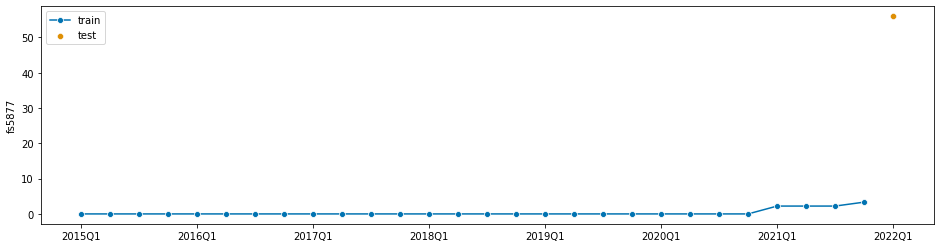

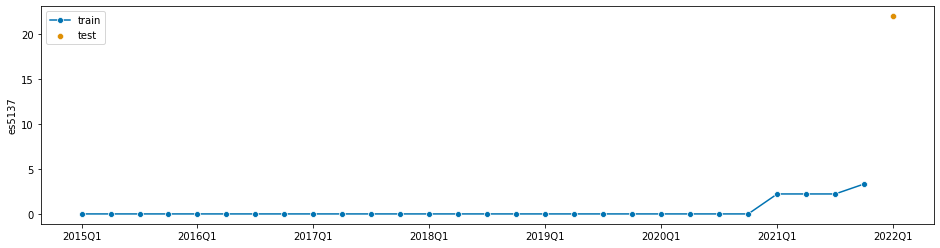

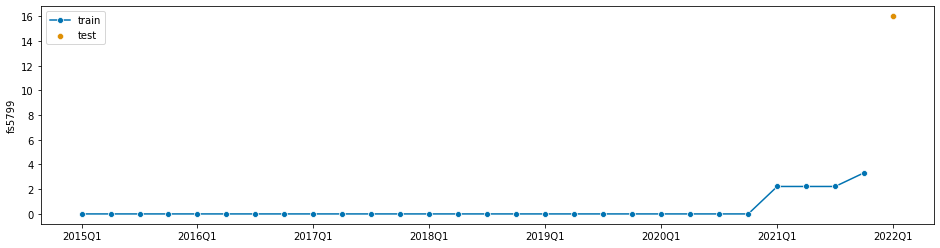

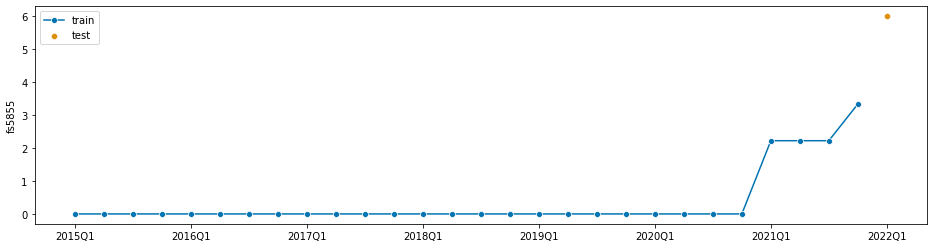

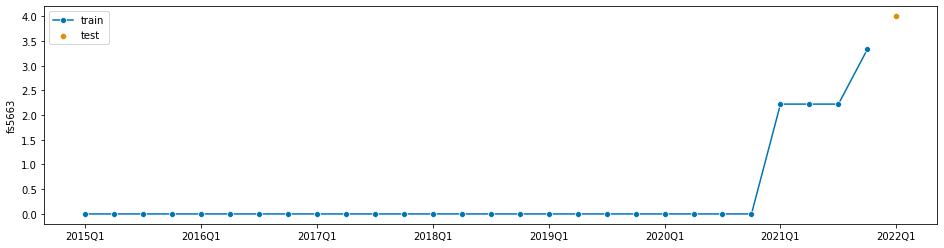

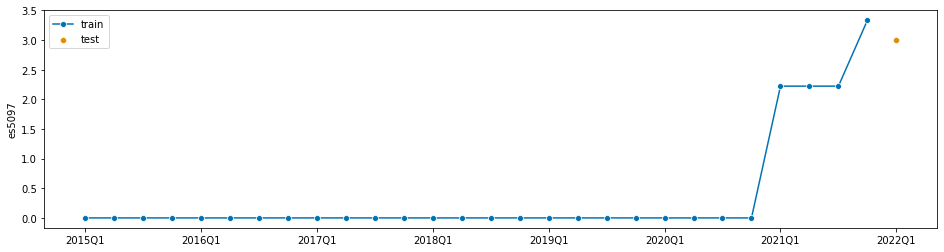

In [63]:
for i in model_failure_SARIMA:
    plot_series(y_train.loc[:,i], y_test.loc[:,i], labels = ['train','test']);

In [64]:
sarima_preds = sarima_preds.drop(columns=model_failure_SARIMA)

In [65]:
sarima_y_test = y_test.drop(columns=model_failure_SARIMA)

In [66]:
sarima_y_test

style_id,es3203,es3204,fs4656,es2811,ch2564,es3202,ch2565,ch2891,fs4835,es5130,...,fs5916,fs5915,fs5914,fs5907,fs5903,fs5902,fs5901,fs5898,es5165,me3220
2022Q1,80.0,74.0,70.0,65.0,51.0,50.0,50.0,44.0,41.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
pred_rmse(sarima_y_test, sarima_preds)

14.53489621400233

In [68]:
sarima_y_train = y_train.drop(columns=model_failure_SARIMA)

In [69]:
sarima_y_train.shape, sarima_y_test.shape, sarima_preds.shape

((28, 259), (1, 259), (1, 259))

In [70]:
sarima_y_test

style_id,es3203,es3204,fs4656,es2811,ch2564,es3202,ch2565,ch2891,fs4835,es5130,...,fs5916,fs5915,fs5914,fs5907,fs5903,fs5902,fs5901,fs5898,es5165,me3220
2022Q1,80.0,74.0,70.0,65.0,51.0,50.0,50.0,44.0,41.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
sarima_preds.index

PeriodIndex(['2022Q1'], dtype='period[Q-DEC]')

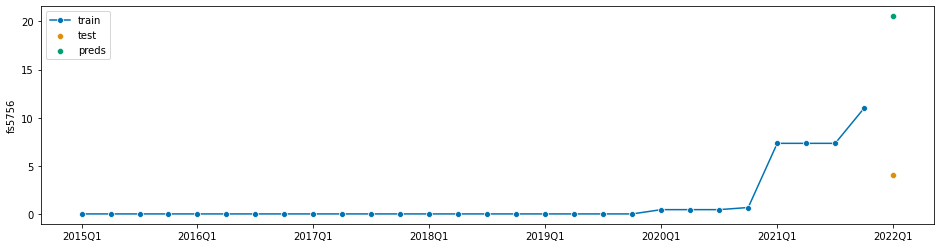

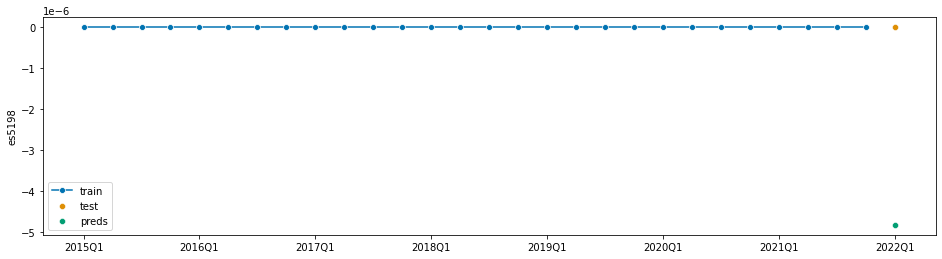

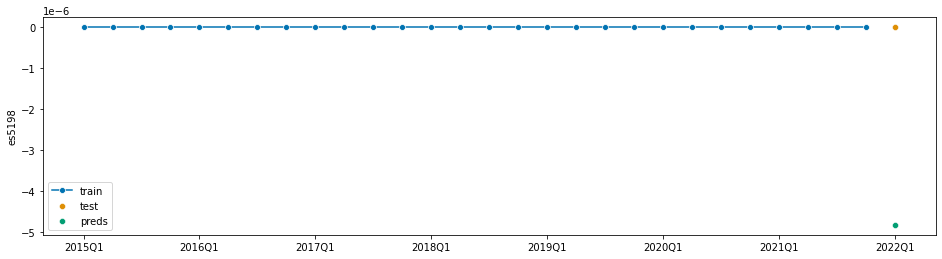

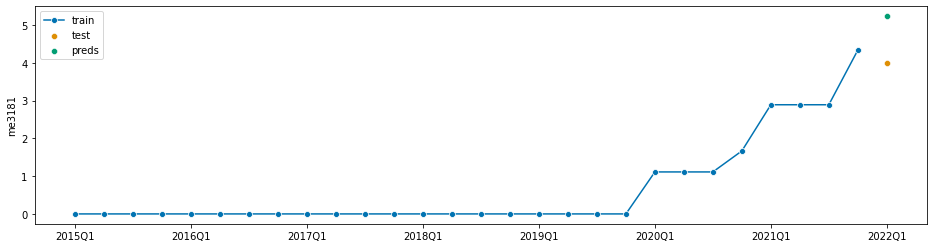

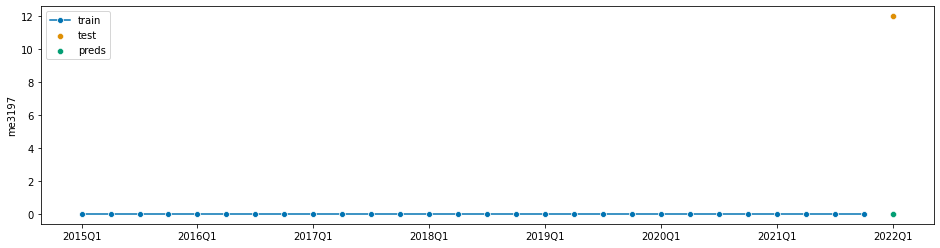

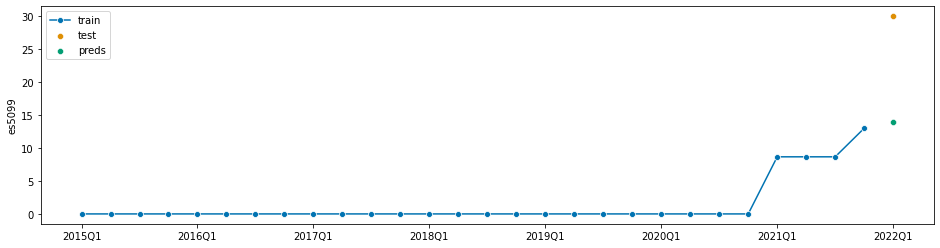

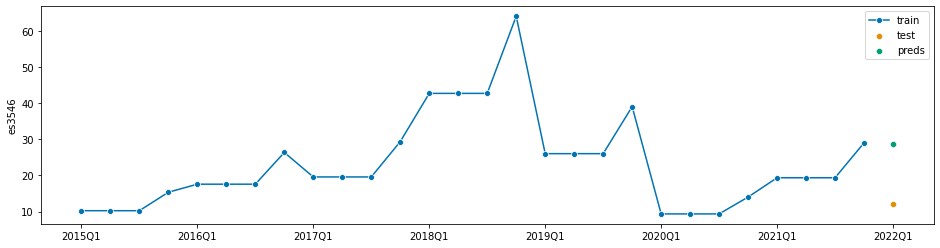

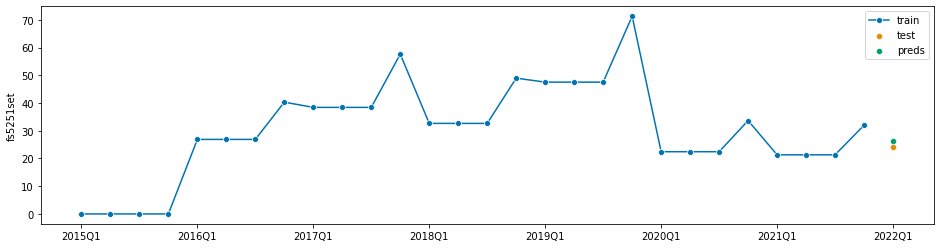

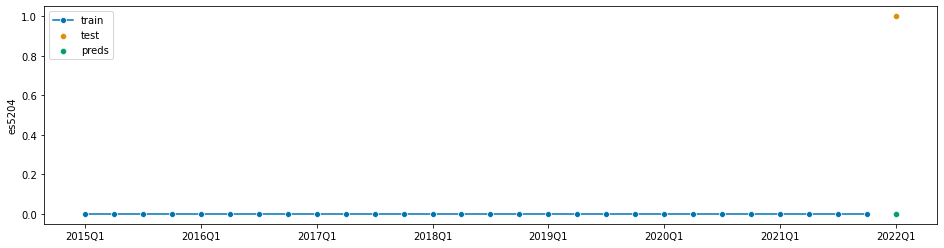

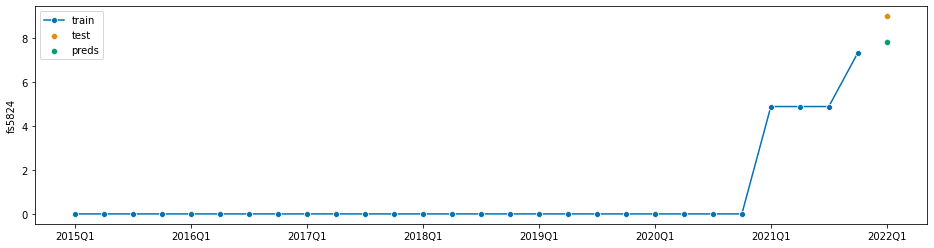

In [72]:
plot_pred(sarima_y_train, sarima_y_test, sarima_preds)